# UPDATED VERSION
- Created to check effect of trimming **outliers and scaling data** on classifiers.
- To check results without cleaning or scaling the better thing is to visualize the two W19 notebooks side by side.
- Results summary:
    - We see that classification performance gets better for K-Neighbors and GMM, and worse for GaussianNaiveBayes, LDA, QDA: the better-performing classifiers got even better, the worse ones got even worse.
    - An interesting effect for GaussianNaiveBayes, despite the overall worsening, is that it gets much better while using only the least informative feature.

# Exercise 19: Classification of galaxies vs quasars

The dataset is at `solutions/galaxyquasar.csv` (I extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...


- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?

---

In [22]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, 
                                           QuadraticDiscriminantAnalysis)

from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_validate

from astroML.classification import GMMBayes
from astroML.utils import completeness_contamination
from astroML.utils import pickle_results

import corner
import pandas as pd
from IPython.display import display

%config InlineBackend.figure_format='retina'

## Data processing

In [2]:
file = '../solutions/galaxyquasar.csv'
data_csv = np.genfromtxt(file, delimiter=',', usecols=(0,1,2,3,4,5), dtype = str)
print(data_csv)

[['u' 'g' 'r' 'i' 'z' 'class']
 ['18.97213' '18.53676' '18.5828' '18.34936' '18.29215' 'QSO']
 ['19.24592' '17.47646' '16.47817' '16.04472' '15.68851' 'GALAXY']
 ...
 ['18.62718' '17.30876' '16.87371' '16.62399' '16.42296' 'GALAXY']
 ['19.5514' '18.27711' '17.62101' '17.21947' '17.03347' 'GALAXY']
 ['18.80772' '17.75751' '17.405' '17.2165' '17.12295' 'GALAXY']]


In [3]:
lab = np.char.replace(data_csv[1:,5], 'GALAXY', '0')
lab = np.char.replace(lab, 'QSO', '1').astype(int)

ug = data_csv[1:,0].astype(float) - data_csv[1:,1].astype(float)
gr = data_csv[1:,1].astype(float) - data_csv[1:,2].astype(float)
ri = data_csv[1:,2].astype(float) - data_csv[1:,3].astype(float)
iz = data_csv[1:,3].astype(float) - data_csv[1:,4].astype(float)

data = np.column_stack((ug,gr,ri,iz))

galaxies = data[: , :4][lab==1].astype(float)
quasars = data[: , :4][lab==0].astype(float)

names = ['u-g', 'g-r', 'r-i', 'i-z']

First we check the distribution of the features

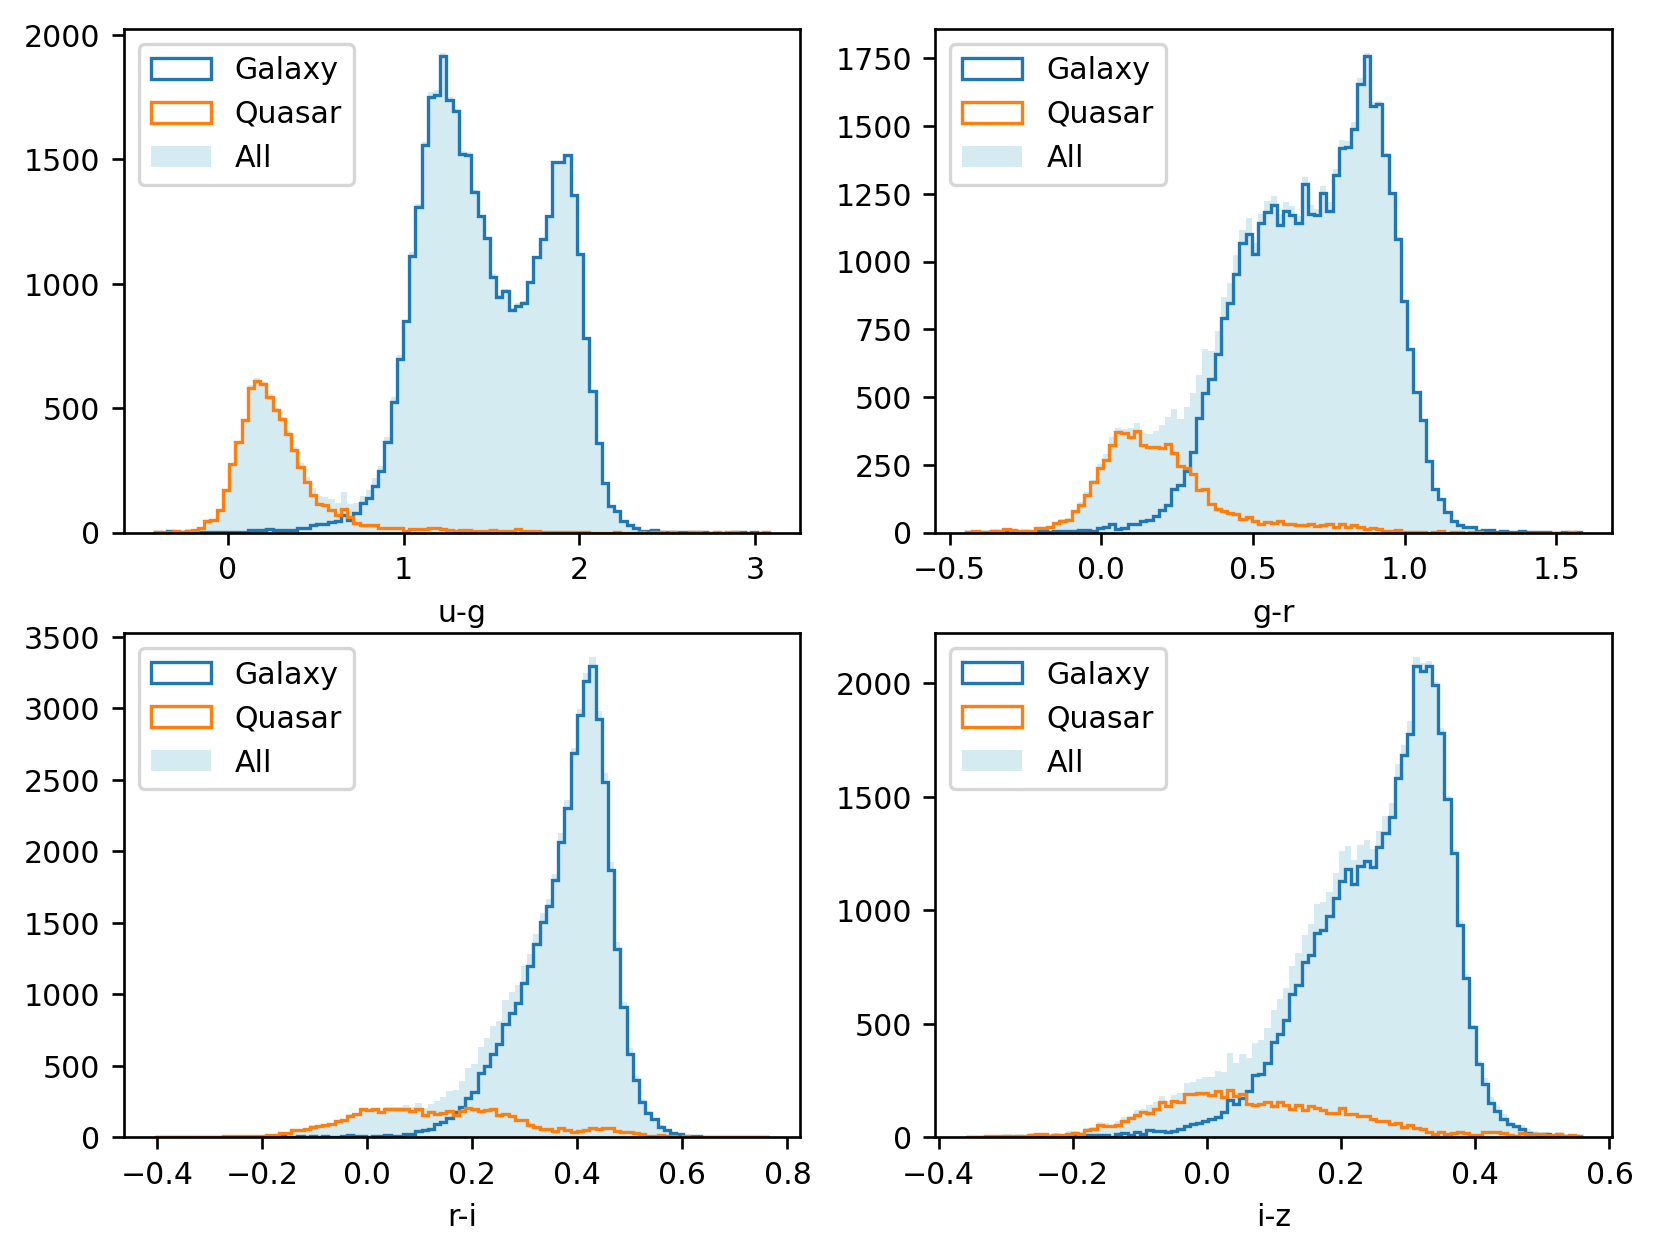

In [4]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(8,6), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig, axs = plt.subplots(2,2)

# bins = 'auto'
quant_list = [(0.0005, 0.9995),(0.001, 0.9995),(0.001, 0.999),(0.003, 0.997)] # Got boundaries by eye
bounds = []

for ax,color, name, quant in zip(axs.flatten() ,data[:,:4].T,names, quant_list):
    
    min, max = np.quantile(color, quant)
    # min = np.min(color)
    # max = np.max(color)
    
    bounds.append([min,max])
    bins = np.linspace(min, max, 100)   
    gala = color[lab==0]
    quas = color[lab==1]
    ax.hist(gala, bins=bins, histtype = 'step', label = 'Galaxy', lw=1)
    ax.hist(quas, bins=bins, histtype = 'step', label = 'Quasar', lw=1)
    ax.hist(color, bins=bins, label = 'All', color='lightblue', alpha=0.5,)
    ax.legend()
    ax.set_xlabel(name)
    # ax.set_yscale('log')
    
plt.tight_layout;

From color distributions it seems that u-g is by far the most informative feature as it shows a clear bimodality differentiating galaxies and quasars. For the other colors, quasars only create a small bump in the total distribution.

In the above histograms we choose x axes boundaries using data quantiles to exclude outliers and look at bulk distributions for each color. 

Checking histograms including all data we see that there are some outliers: we trim them from the data sample.


In [5]:
# Remove outliers
bounds = np.array(bounds)
data_t = data.T

# mask on transposed data matrix
mask1 = np.array([np.logical_and(bounds[i,0] < data.T[i], data.T[i] < bounds[i,1]) for i in [0,1,2,3]])
mask2 = np.all(mask1,axis=0)

data_clean = data[mask2,:]
lab_clean = lab[mask2]

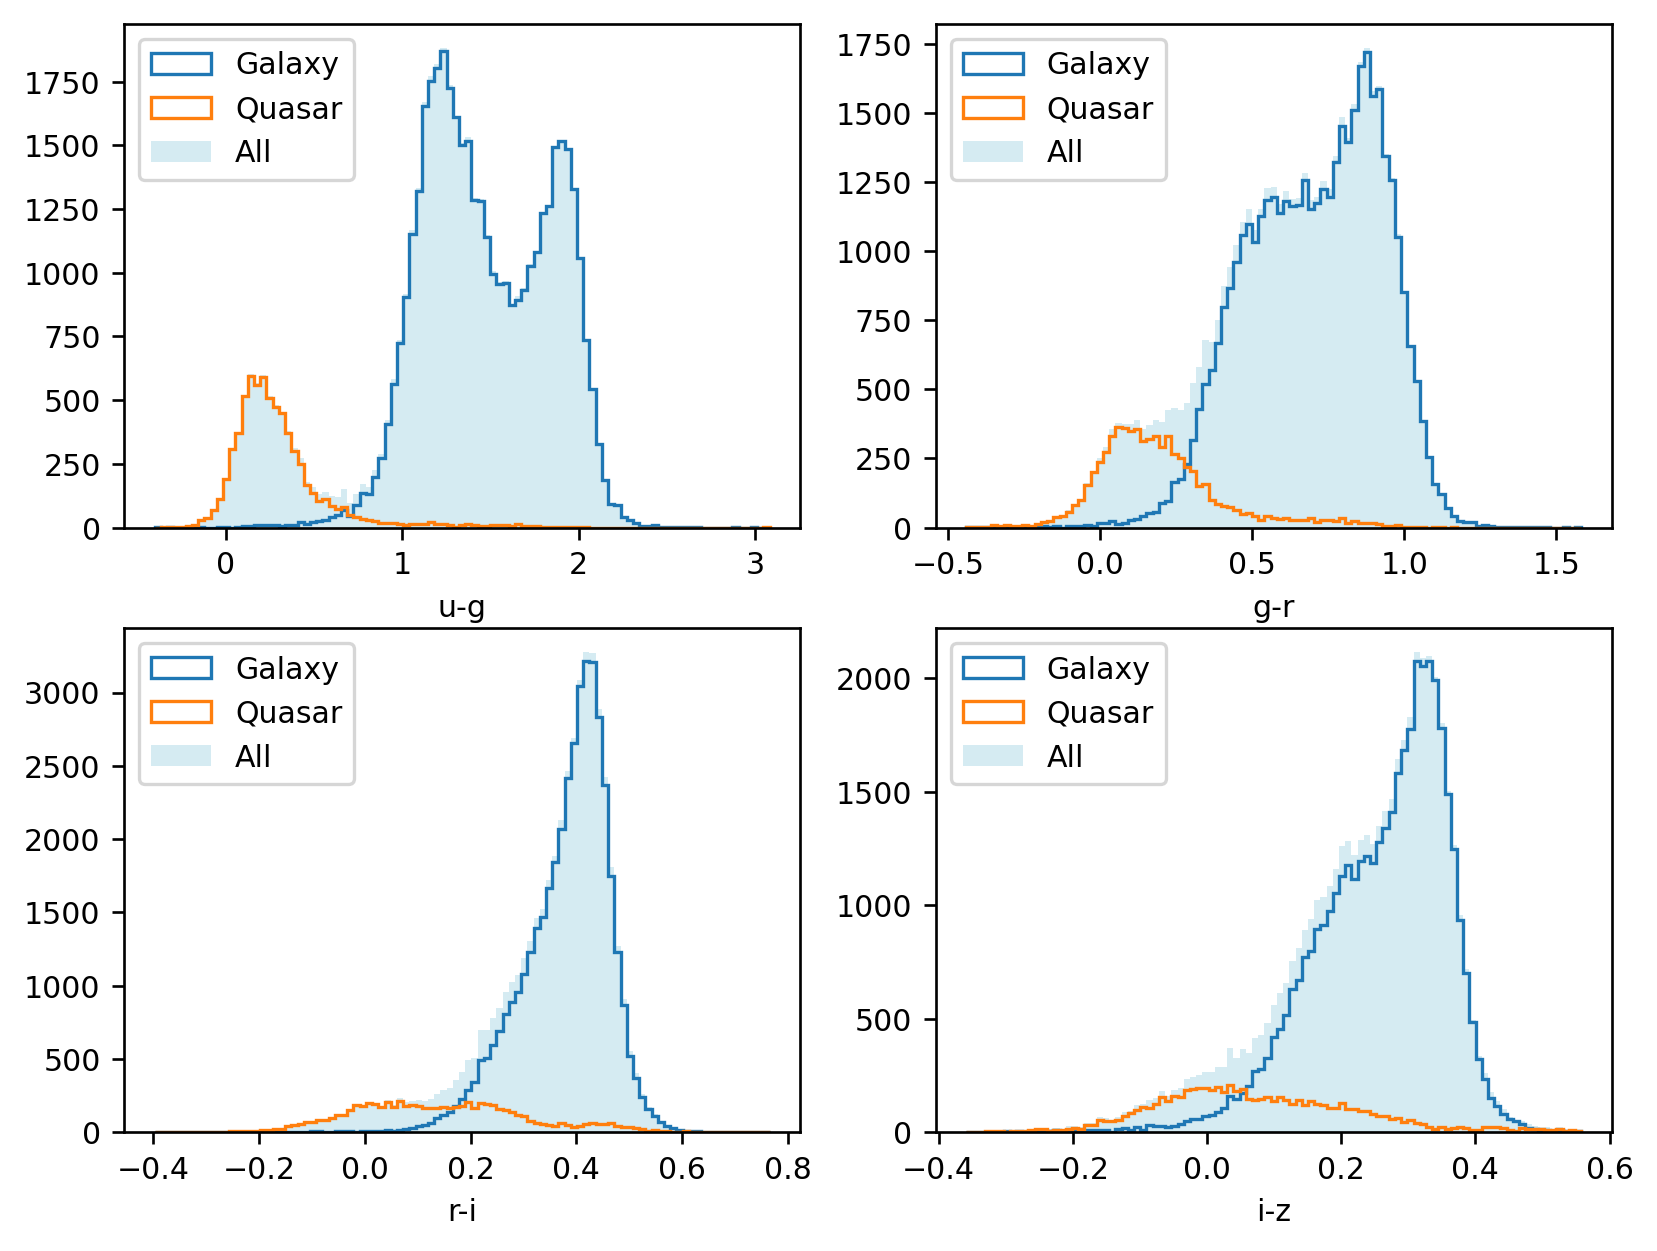

In [6]:
# Check if we selected right data

#-------  Plt params  ----------------
plt.rc('figure', figsize=(8,6), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig, axs = plt.subplots(2,2)

for ax,color, name in zip(axs.flatten() ,data_clean[:,:4].T,names):
    bins = np.linspace(np.min(color), np.max(color), 100)
    gala = color[lab_clean==0]
    quas = color[lab_clean==1]
    ax.hist(gala, bins=bins, histtype = 'step', label = 'Galaxy', lw=1)
    ax.hist(quas, bins=bins, histtype = 'step', label = 'Quasar', lw=1)
    ax.hist(color, bins=bins, label = 'All', color='lightblue', alpha=0.5,)
    ax.legend()
    ax.set_xlabel(name)
    # ax.set_yscale('log')
    
plt.tight_layout;

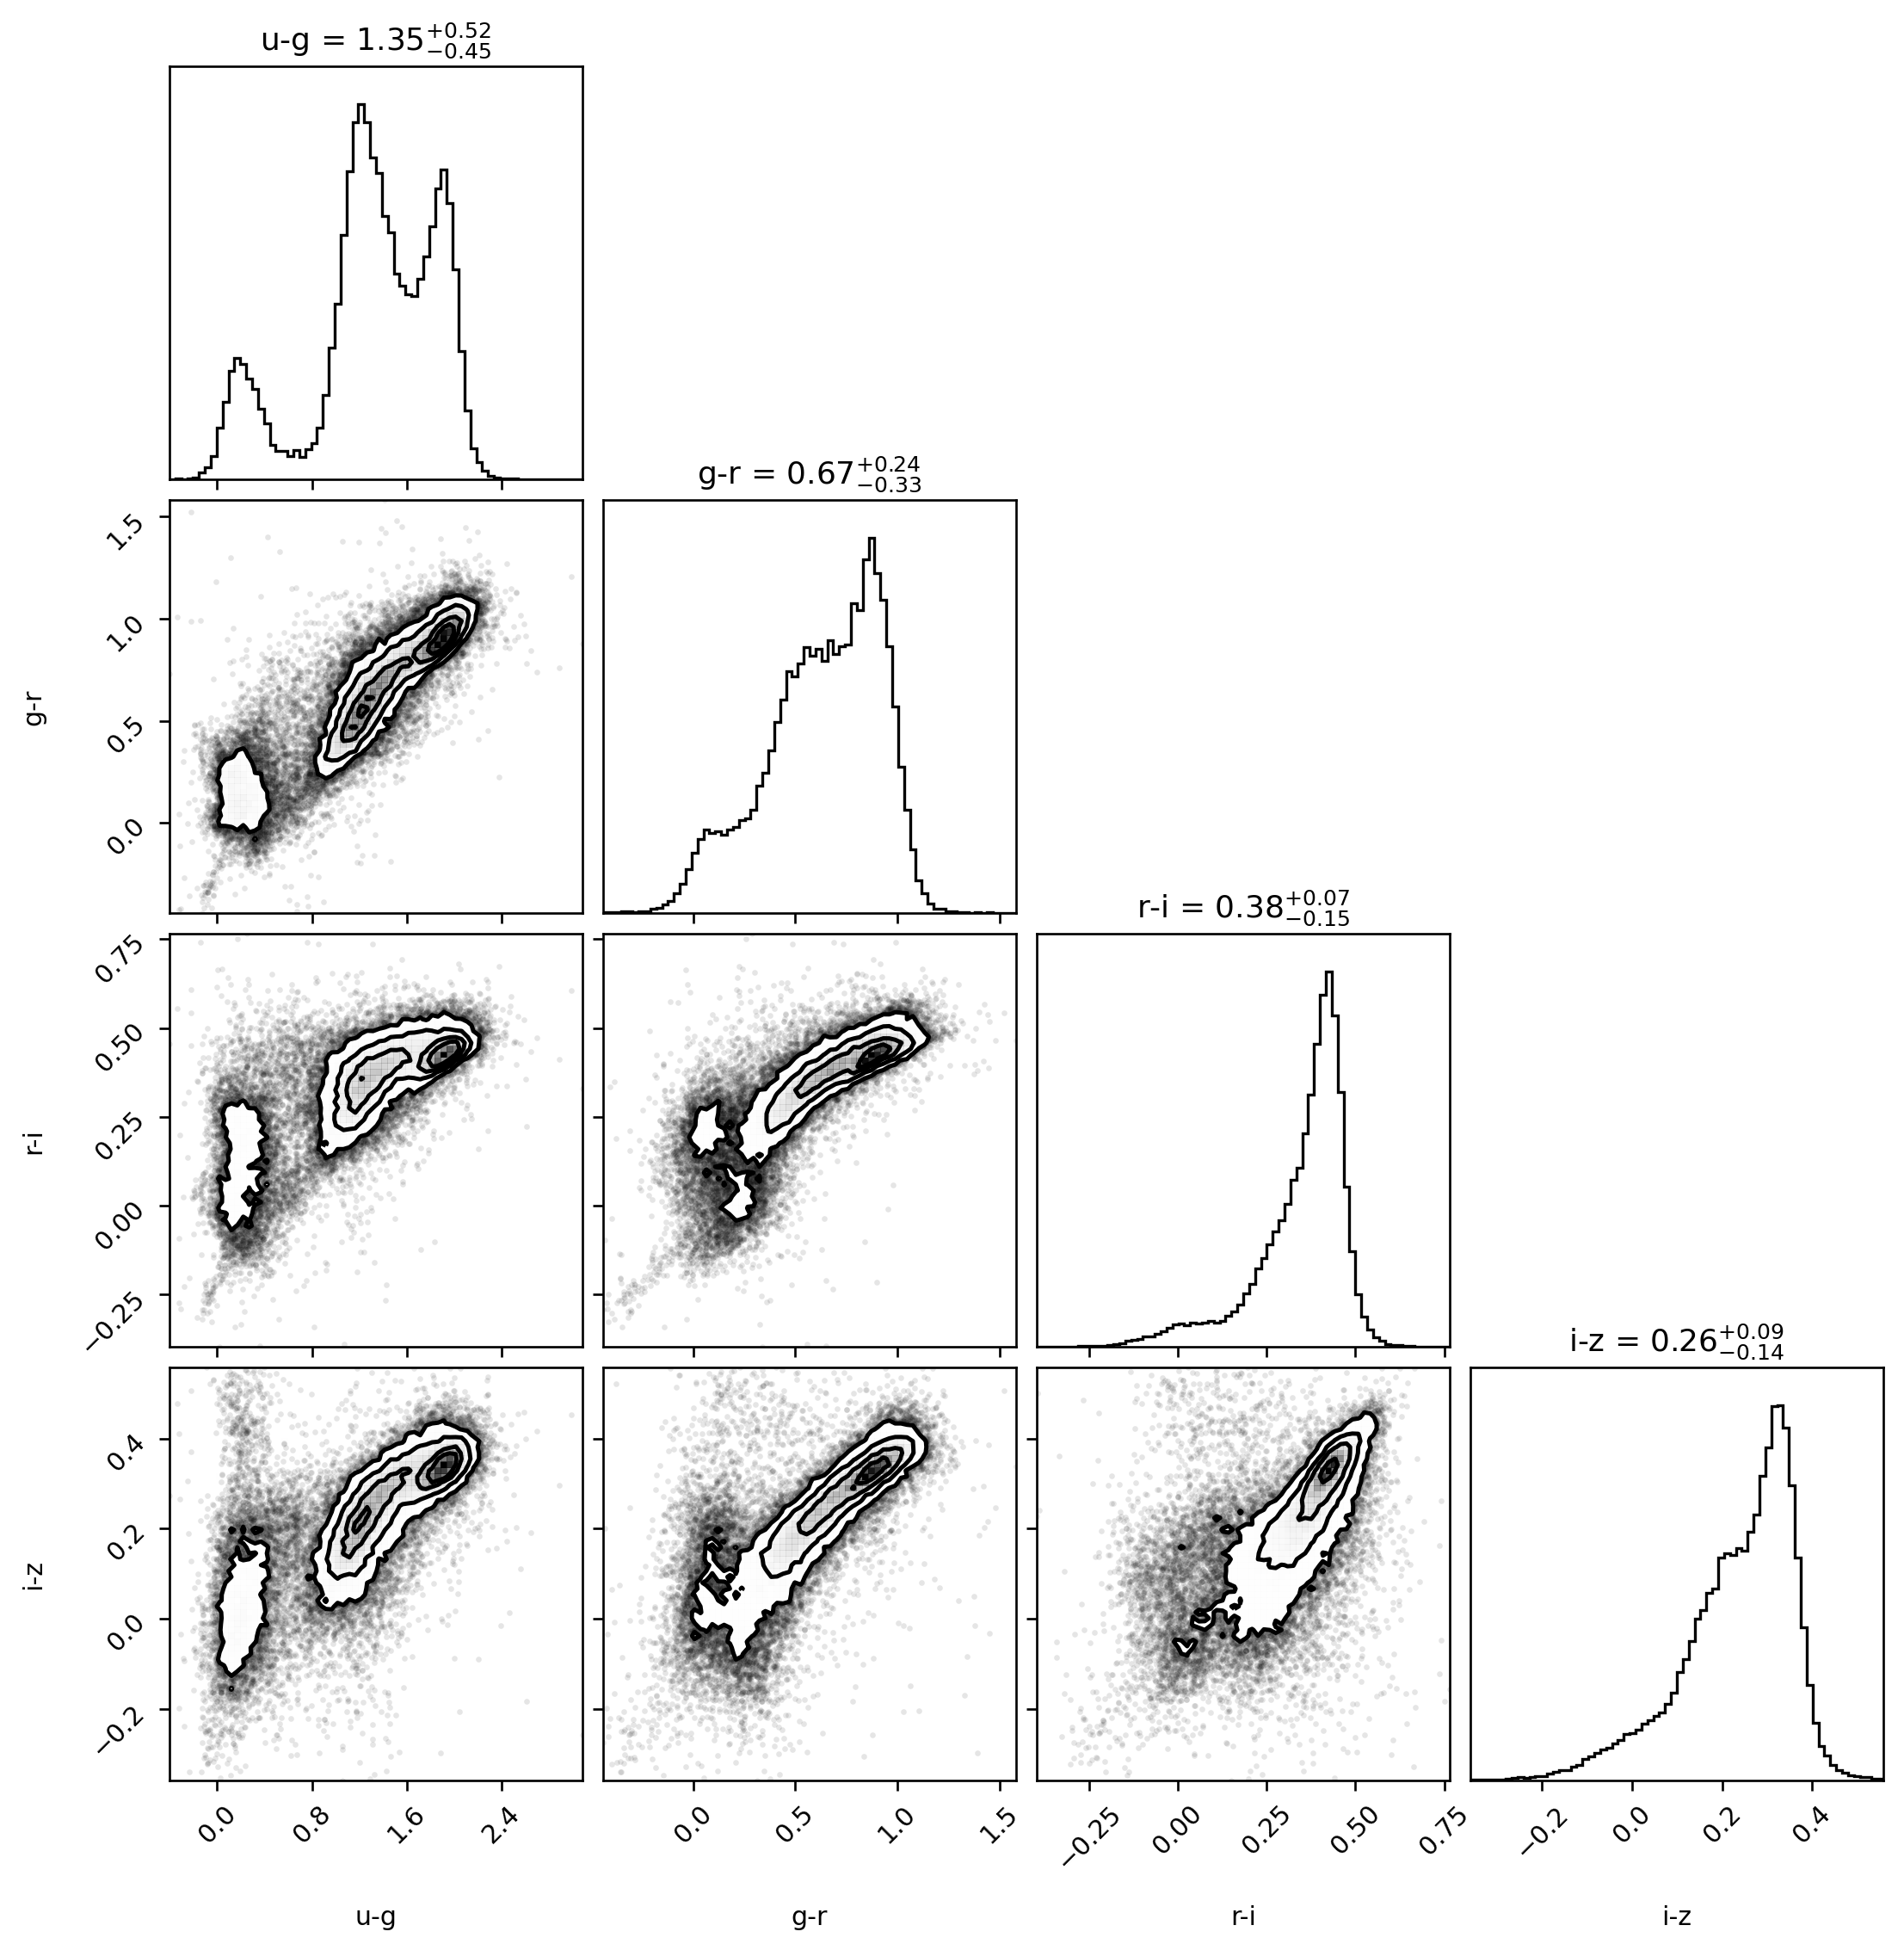

In [7]:
corner.corner(data_clean, labels = names, bins=70, show_titles=True);

We can clearly see correlation among all the features. This will impact the performance of naive classifiers.

Now we normalize data and split in train and test sets:

In [8]:
# Train and test sets
X = data_clean
y = lab_clean

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=0)

# Scaling data after split to avoid information leakage from test 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Comparing classifiers

In [24]:
# USEFUL FUNCTIONS
###################################################

def run_classifier(clf, **kwargs):
    '''
    Trains and evaluates performance of a single classifier
        
    Input: clf(sklearn classifier object), name(str)
    Output: list of "info" containing a list of [metrics, curves], clf params, clf input name
    
    Kwargs: 
    
    proba = True, can be set to False if the classifier doeas not have predict_proba() method (like SVC).
    name = 'custom_name' , to use custom name.
    test_set = False , can be set to True to compute metrics on the test set.
    kfolds = 5, number of folds for CV for computing metrics using the train set
    '''
    # Setting default kwargs
    name = kwargs.get('name', str(clf) )
    proba = kwargs.get('proba', True )
    test_metrics = kwargs.get('test_metrics', False)
    kfolds = kwargs.get('kfolds', 5)
    
    print(f'Fitting {name}')

    clf.fit(X_train, y_train) # Fit classifier
    
    if proba == False:
        y_probs = clf.decision_function(X_test)
    else:
        y_probs = clf.predict_proba(X_test)[:, 1]
        
    y_pred = clf.predict(X_test)
    
    #-------------------------------------------------------------------------------
    if test_metrics == True:
        complet = recall_score(y_test, y_pred)
        contam = 1 - precision_score(y_test, y_pred)
        accur = accuracy_score(y_test, y_pred)
        sigmas = np.array([.0,.0, .0])
    else:
        score_list = ['accuracy', 'recall', 'precision' ]
        cv_results = cross_validate(clf, X_train, y_train, scoring = score_list, 
                                    n_jobs=-1, verbose=1, cv=kfolds )

        accur = np.mean(cv_results['test_accuracy'])
        accur_sigma = np.std(cv_results['test_accuracy'])
        complet = np.mean(cv_results['test_recall'])
        complet_sigma = np.std(cv_results['test_recall'])
        contam = np.mean(1 - cv_results['test_precision'])
        contam_sigma = np.std(1 - cv_results['test_precision'])
        
        sigmas = np.array([accur_sigma, complet_sigma, contam_sigma])
        
    #-------------------------------------------------------------------------------    
    
    metrics = np.array([accur, complet, contam])
    
    
    fpr, tpr, thresh = roc_curve(y_test, y_probs)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_probs)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    
    curves = [[fpr,tpr],[precision,recall]]
    
    results = [metrics, curves, sigmas]
    params = clf.get_params()
    
    info = [results, params, name]
    return  info

###################################################

def run_classifier_list (classifiers_list, **kwargs):
    '''
    DO NOT USE WITH SVC etc (without .predict_proba() method): use run_classifier() on the single clf and then append info manually
    
    Trains and evalutate performance of a list of classifiers
   
    Inputs: list of classifiers, listo of names
    Output: list of "info" lists from run_classifier() function
    
    kwargs:
    names = ['name1','name2',..] , to use custom name list for classifiers
    test_metrics =False , can be set to True to compute metrics on the test set
    kfolds = 5, number of folds for CV for computing metrics using the train set
    '''
    
    names = kwargs.get('names', [str(clf) for clf in classifiers_list] )
    test_metrics = kwargs.get('test_metrics',False)
    kfolds = kwargs.get('kfolds', 5)
    
    info_list = []
    for clf, name in zip(classifiers_list,names):
        info_list.append(run_classifier(clf, name=name, test_metrics=test_metrics, kfolds=kfolds ))
    return info_list

###################################################

def compare_classifiers(info_list, plot_curves = True, plot_metrics_bars = True, figtitle='none'):
    ''' 
    Compares performance of classifiers evaluated beforehand.
    
    Input: list of outputs from run_classifier()
    Output: metrics pd.DataFrame, list of params of the classifiers
    
    kwargs:
    figtitle = 'chosen title' , to set a chosen title for the two figures
    '''
    
    results_list = [info[0] for info in info_list]
    params_list = [info[1] for info in info_list]
    names = [info[2] for info in info_list]

    metrics_arr = np.array([results[0] for results in results_list]).T
    sigmas_arr = np.array([results[2] for results in results_list]).T
    keys = ['name', 'accuracy', 'completeness', 'contamination']
    metrics_d = dict(zip(keys,[names, *metrics_arr]))
    
    metrics_dataframe = pd.DataFrame(metrics_d).sort_values("accuracy", ascending=False)
    display(metrics_dataframe)
    
    if plot_curves == True:
        
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(9, 4.5), dpi=120)
        plt.rcParams.update({'font.size': 9})         
        #--------------------------------------------
        
        # fig = plt.figure()
        fig, axs = plt.subplots(1,2)
        
        if figtitle != 'none':
            fig.suptitle(figtitle, fontsize=16)
        
        ax1 = axs[0]
        ax2 = axs[1]
        
        # fig.subplots_adjust(hspace=0.5, wspace=0.5)

        for results,name  in zip(results_list,names):
            curves = results[1]
            roc = curves[0]
            prec_rec = curves[1]
            ax1.plot(roc[0],roc[1], label=name)
            ax2.plot(prec_rec[0], prec_rec[1], label=name)
            
        ax1.set_xlabel('false positive rate')
        ax1.set_ylabel('true positive rate')
        ax1.set_title('ROC curves')
        ax1.legend(loc=4)
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))        
        ax1.set_xlim(0, 1.0)
        ax1.set_ylim(0.9, 1.01)
        ax2.set_xlabel('precision')
        ax2.set_ylabel('recall')
        ax2.set_title('Precision - Recall curves')
        ax2.set_xlim(0, 1.0)
        ax2.set_ylim(0.9, 1.01);
        
        
    if plot_metrics_bars == True:
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(10,5), dpi=120)
        plt.rcParams.update({'font.size': 10})
        #--------------------------------------------

        fig, axs = plt.subplots(1,3)
        fig.subplots_adjust(hspace=0.05, wspace=0.05)
        
        if figtitle != 'none':
            fig.suptitle(figtitle, fontsize=16)
        
        margins = [0.01,0.01,0.01]
        x=1
        labels = ['Accuracy', 'Completeness', 'Contamination']
        width = 1  # the width of the bars
        
        for i,(ax, label) in enumerate(zip(axs.flatten(),labels)):
            j=0
            for name, metrics, sigmas in zip(names, metrics_arr.T, sigmas_arr.T):
                rect = ax.bar(x+width*j, metrics[i], width, label=name)
                ax.errorbar(x+width*j, metrics[i], yerr=sigmas[i],  fmt='.k', ecolor='gray', lw=1, capsize = 2, markersize=5)         
                ax.bar_label(rect, padding=3, fmt='%.4f', fontsize=8)
                j+=1
            ax.set_title(label)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_ylim(np.min(metrics_arr[i]-sigmas_arr[i]) - margins[i], np.max(metrics_arr[i]  + sigmas_arr[i]) + margins[i]) 
        axs[0].set_ylabel('Scores')
            
            # Legend next to graph
            # ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1)) 
        
            # Put a vertical legend below current axis
        axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
            
            # Put a horizontal legend below current axis
            # ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
            
        # fig.tight_layout()
            

    return metrics_dataframe, params_list

###################################################


if False:
# To do everything in one go
    def evaluate_classifiers(clf_list, names, plot_curves = True, plot_metrics_bars = True): 
        '''
        Trains and compares different classifiers.
        
        Input: List of classifiers, list of names
        Output: metrics pd.DataFrame and list of classifier params
        If plot = True (default) plots ROC and precision-recall curves
        '''
        info_list = []
        
        for clf,name in zip(clf_list,names): # Run classifiers using above funciton
            info = run_classifier(clf,name)
            info_list.append(info)
            
        metrics_dataframe, params_list = compare_classifiers(info_list, plot_curves, plot_metrics_bars)
                    
        return metrics_dataframe, params_list


In [43]:
# Define classifiers

gnb = GaussianNB()
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
knn = KNeighborsClassifier()
gmm = GMMBayes(n_components=5)

classifiers_list1 = [gnb, lda, qda, knn, gmm]

In [44]:
kf = 20
info_list1 = run_classifier_list(classifiers_list1, test_metrics=False, kfolds=kf) 
# info_list1 = run_classifier_list(classifiers_list1, test_metrics=True) 

Fitting GaussianNB()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


Fitting LinearDiscriminantAnalysis()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


Fitting QuadraticDiscriminantAnalysis()
Fitting KNeighborsClassifier()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


Fitting GMMBayes(n_components=array([5]))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.0s finished


,name,accuracy,completeness,contamination
4,GMMBayes(n_components=array([5])),0.986385,0.944698,0.041982
3,KNeighborsClassifier(),0.986184,0.942648,0.041444
1,LinearDiscriminantAnalysis(),0.980082,0.904767,0.048710
2,QuadraticDiscriminantAnalysis(),0.974670,0.949000,0.119433
0,GaussianNB(),0.957285,0.924017,0.197667


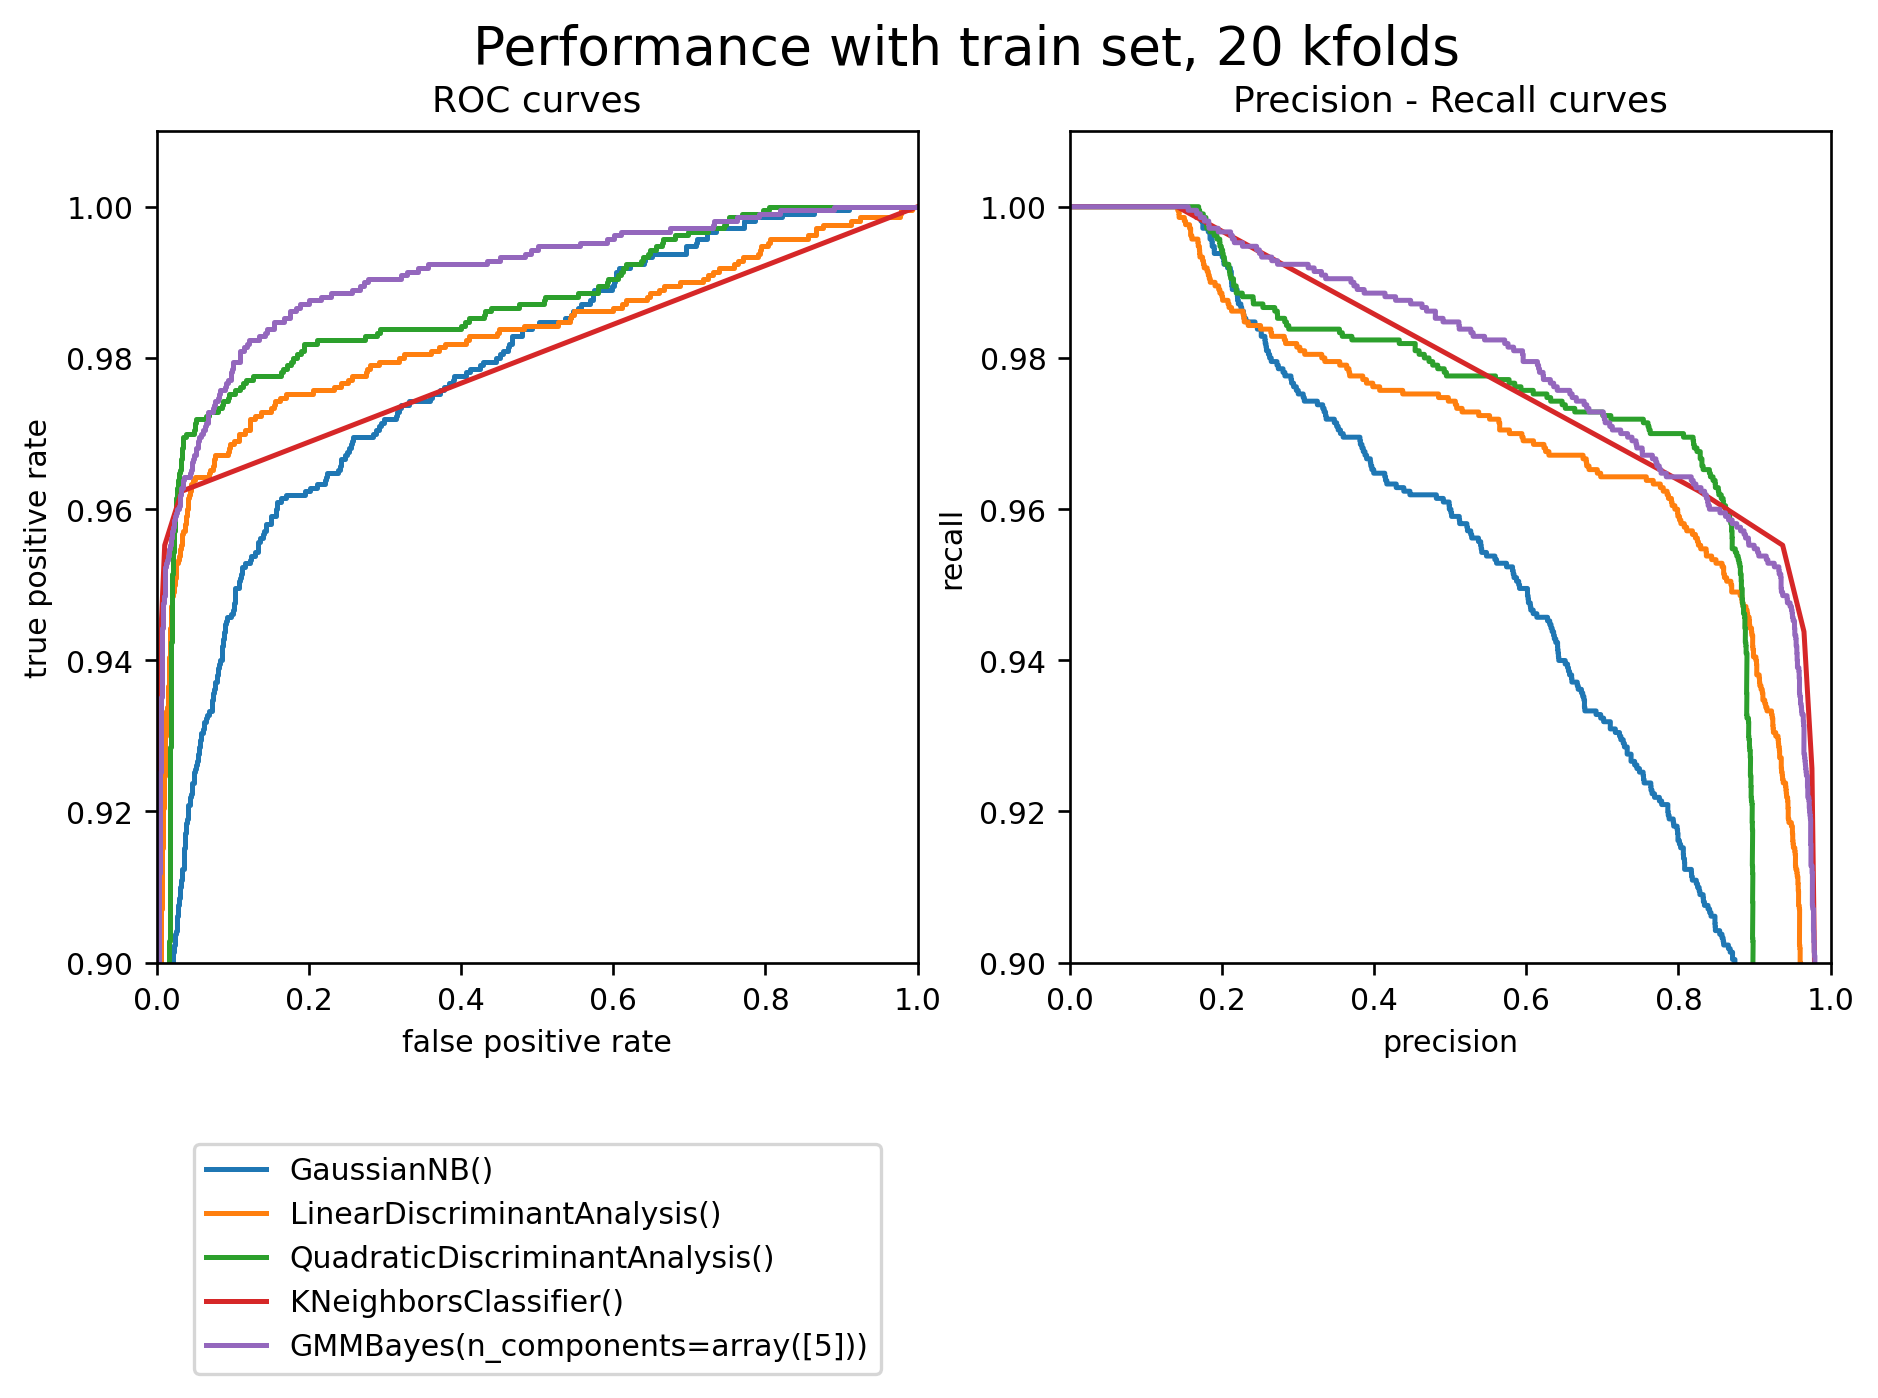

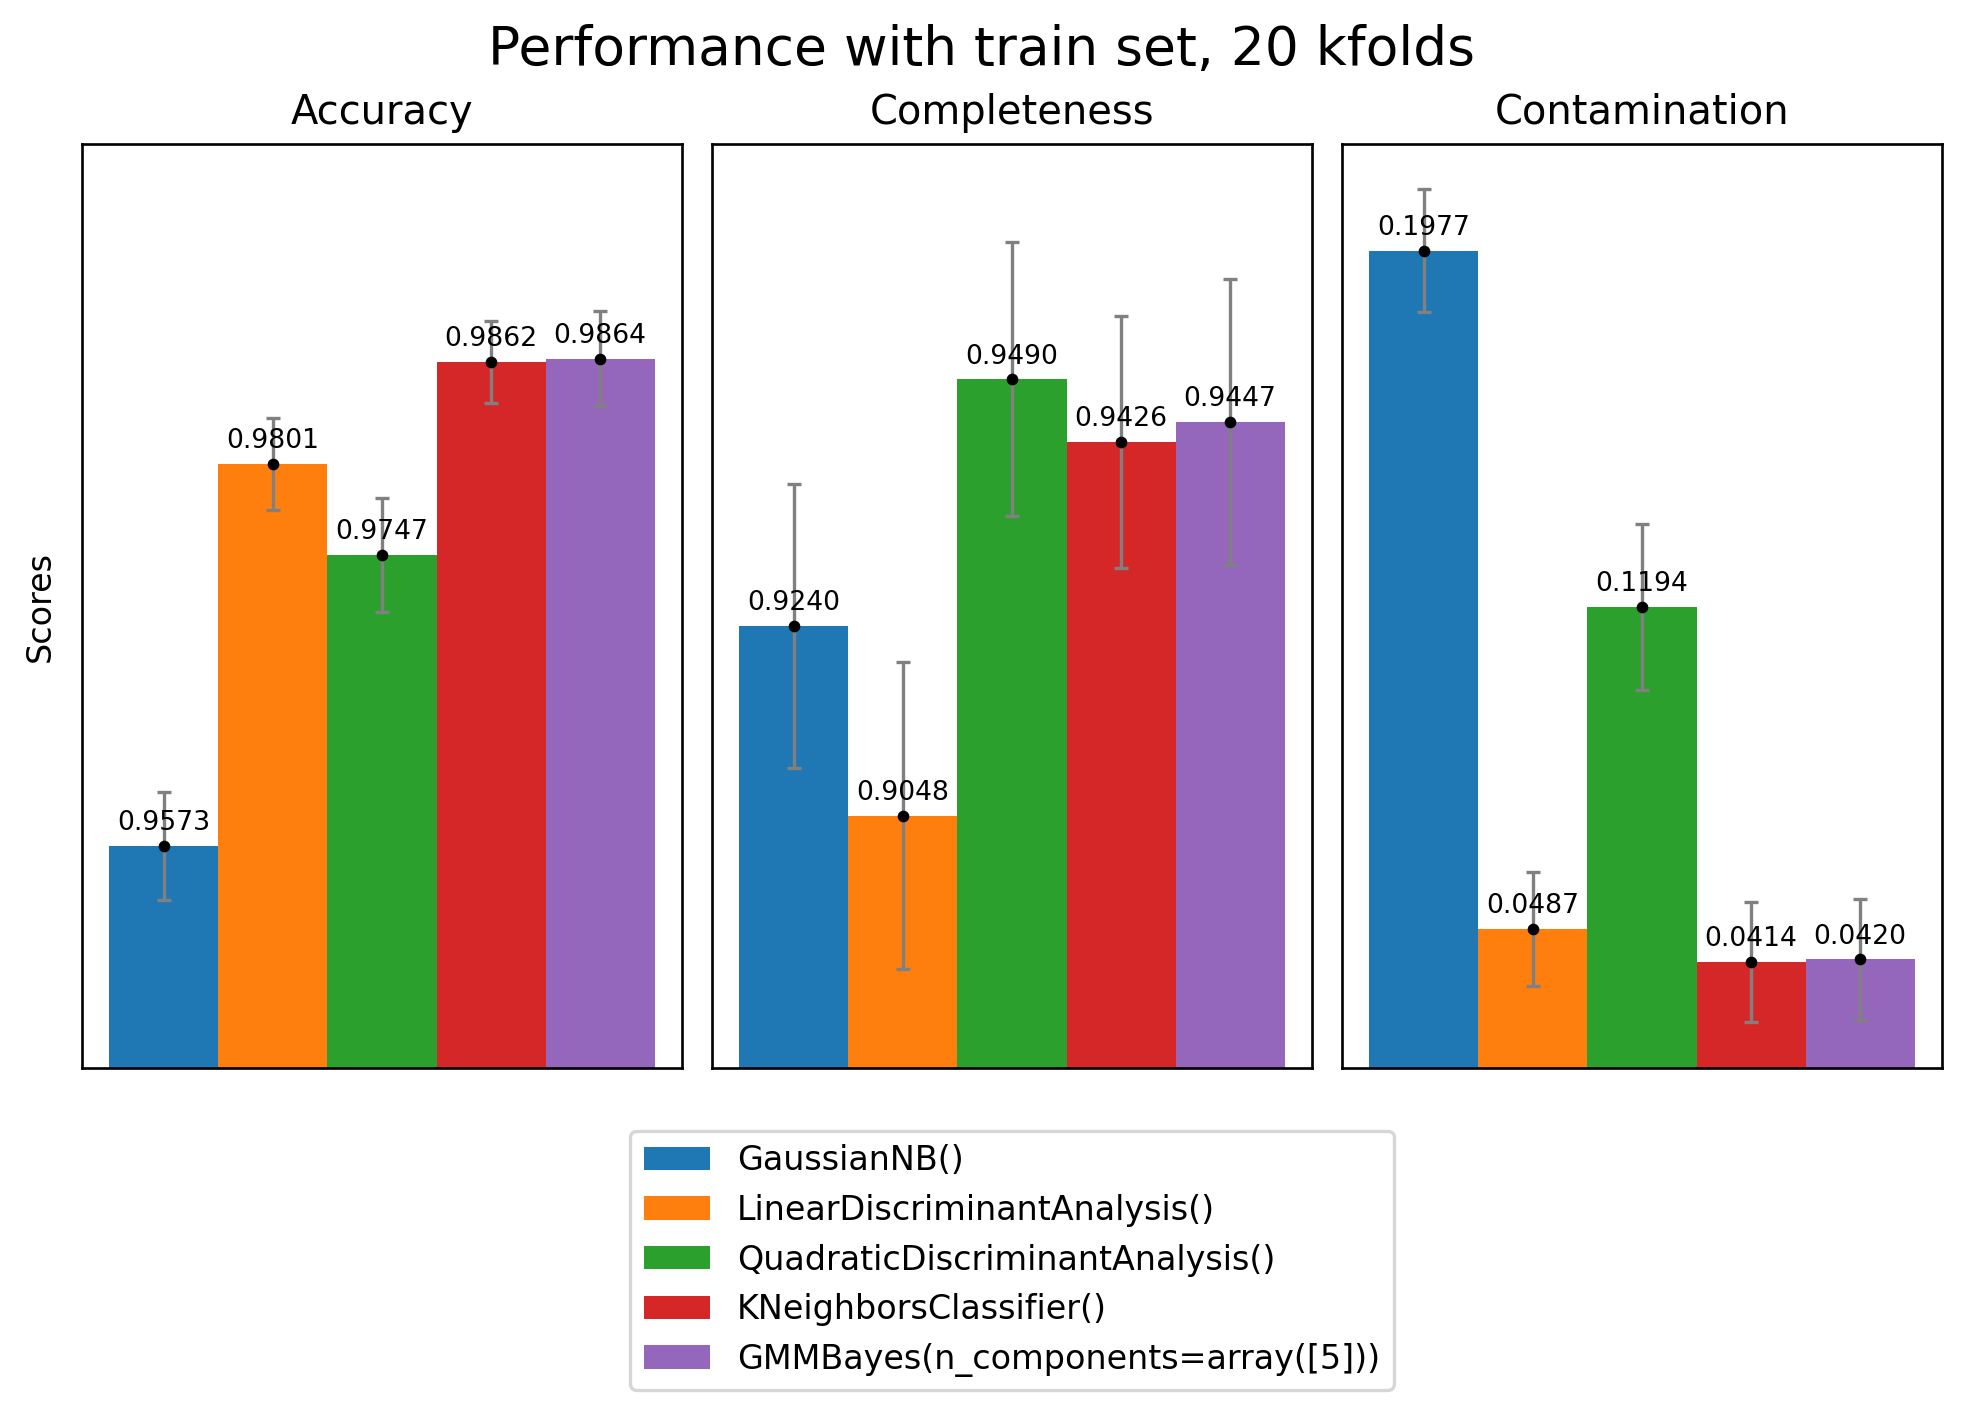

In [45]:
# Change colormap

# cmap=plt.cm.Blues_r
# c = cycler('color', cmap(np.linspace(0,0.5,len(info_list1))) )
# plt.rcParams["axes.prop_cycle"] = c

cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c

a1 = compare_classifiers(info_list1, figtitle=f'Performance with train set, {kf} kfolds' )
# a1 = compare_classifiers(info_list1, figtitle='Performance with test set' )

### CV tuning for best calssifiers
We tune K-neighbors and GMM Bayes with Cross-validation:

In [ ]:
from sklearn.model_selection import GridSearchCV
kvals = np.arange(5,100, 2)
grid = GridSearchCV(KNeighborsClassifier(n_jobs=-1), {'n_neighbors': kvals, 'weights':['distance', 'uniform']}, cv = 20, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

In [36]:
best=[]
best.append(grid.best_params_['n_neighbors'])
best.append(grid.best_params_['weights'])

print(f'Best K = {best[0]}')
print(f'Best weight method = {best[1]}')

Best K = 49
Best weight method = distance


In [ ]:
ncomp = np.arange(2,15, 1)
grid1 = GridSearchCV(GMMBayes(), {'n_components': ncomp}, cv = 15, verbose=1, n_jobs=-1, refit=False)
grid1.fit(X_train, y_train)

In [42]:
bestn = grid1.best_params_['n_components']
print(f'Best n_components = {bestn}')

Best n_components = 11


In [46]:
# Define classifiers

gmm1 = GMMBayes(n_components=5)
gmm2 = GMMBayes(n_components=11)

knn1 = KNeighborsClassifier(n_jobs=-1)
knn2 = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=50)

classifiers_list2 = [gmm1, gmm2, knn1, knn2]

In [ ]:
kf = 20
info_list2 = run_classifier_list(classifiers_list2, test_metrics=False, kfolds=kf) 
# info_list1 = run_classifier_list(classifiers_list1, test_metrics=True) 

,name,accuracy,completeness,contamination
3,"KNeighborsClassifier(n_jobs=-1, n_neighbors=50...",0.986731,0.942857,0.037863
0,GMMBayes(n_components=array([5])),0.986414,0.946132,0.043083
2,KNeighborsClassifier(n_jobs=-1),0.986184,0.942648,0.041444
1,GMMBayes(n_components=array([11])),0.986069,0.942650,0.042226


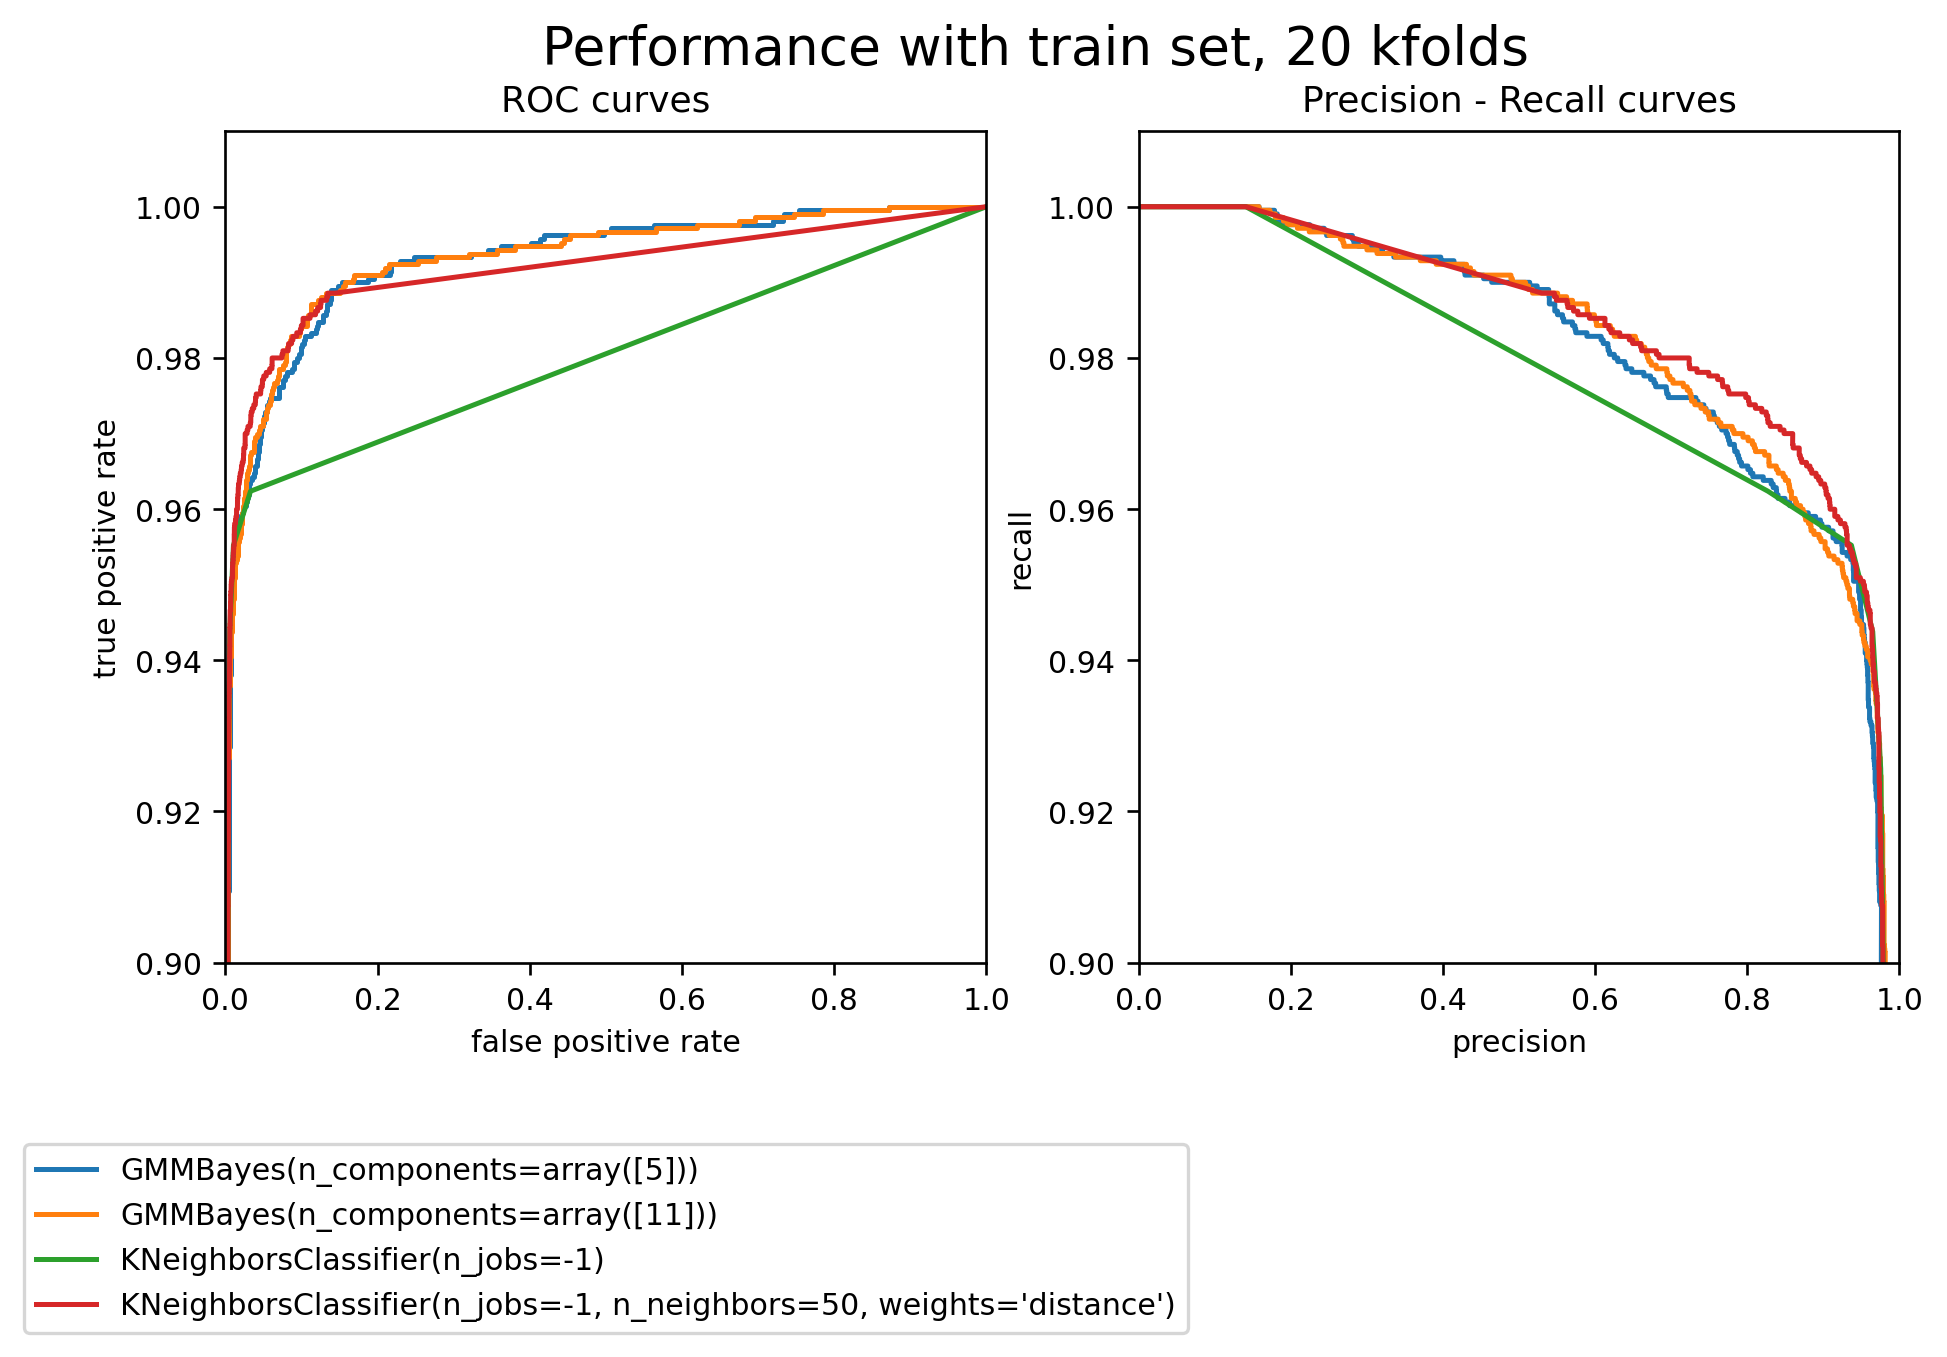

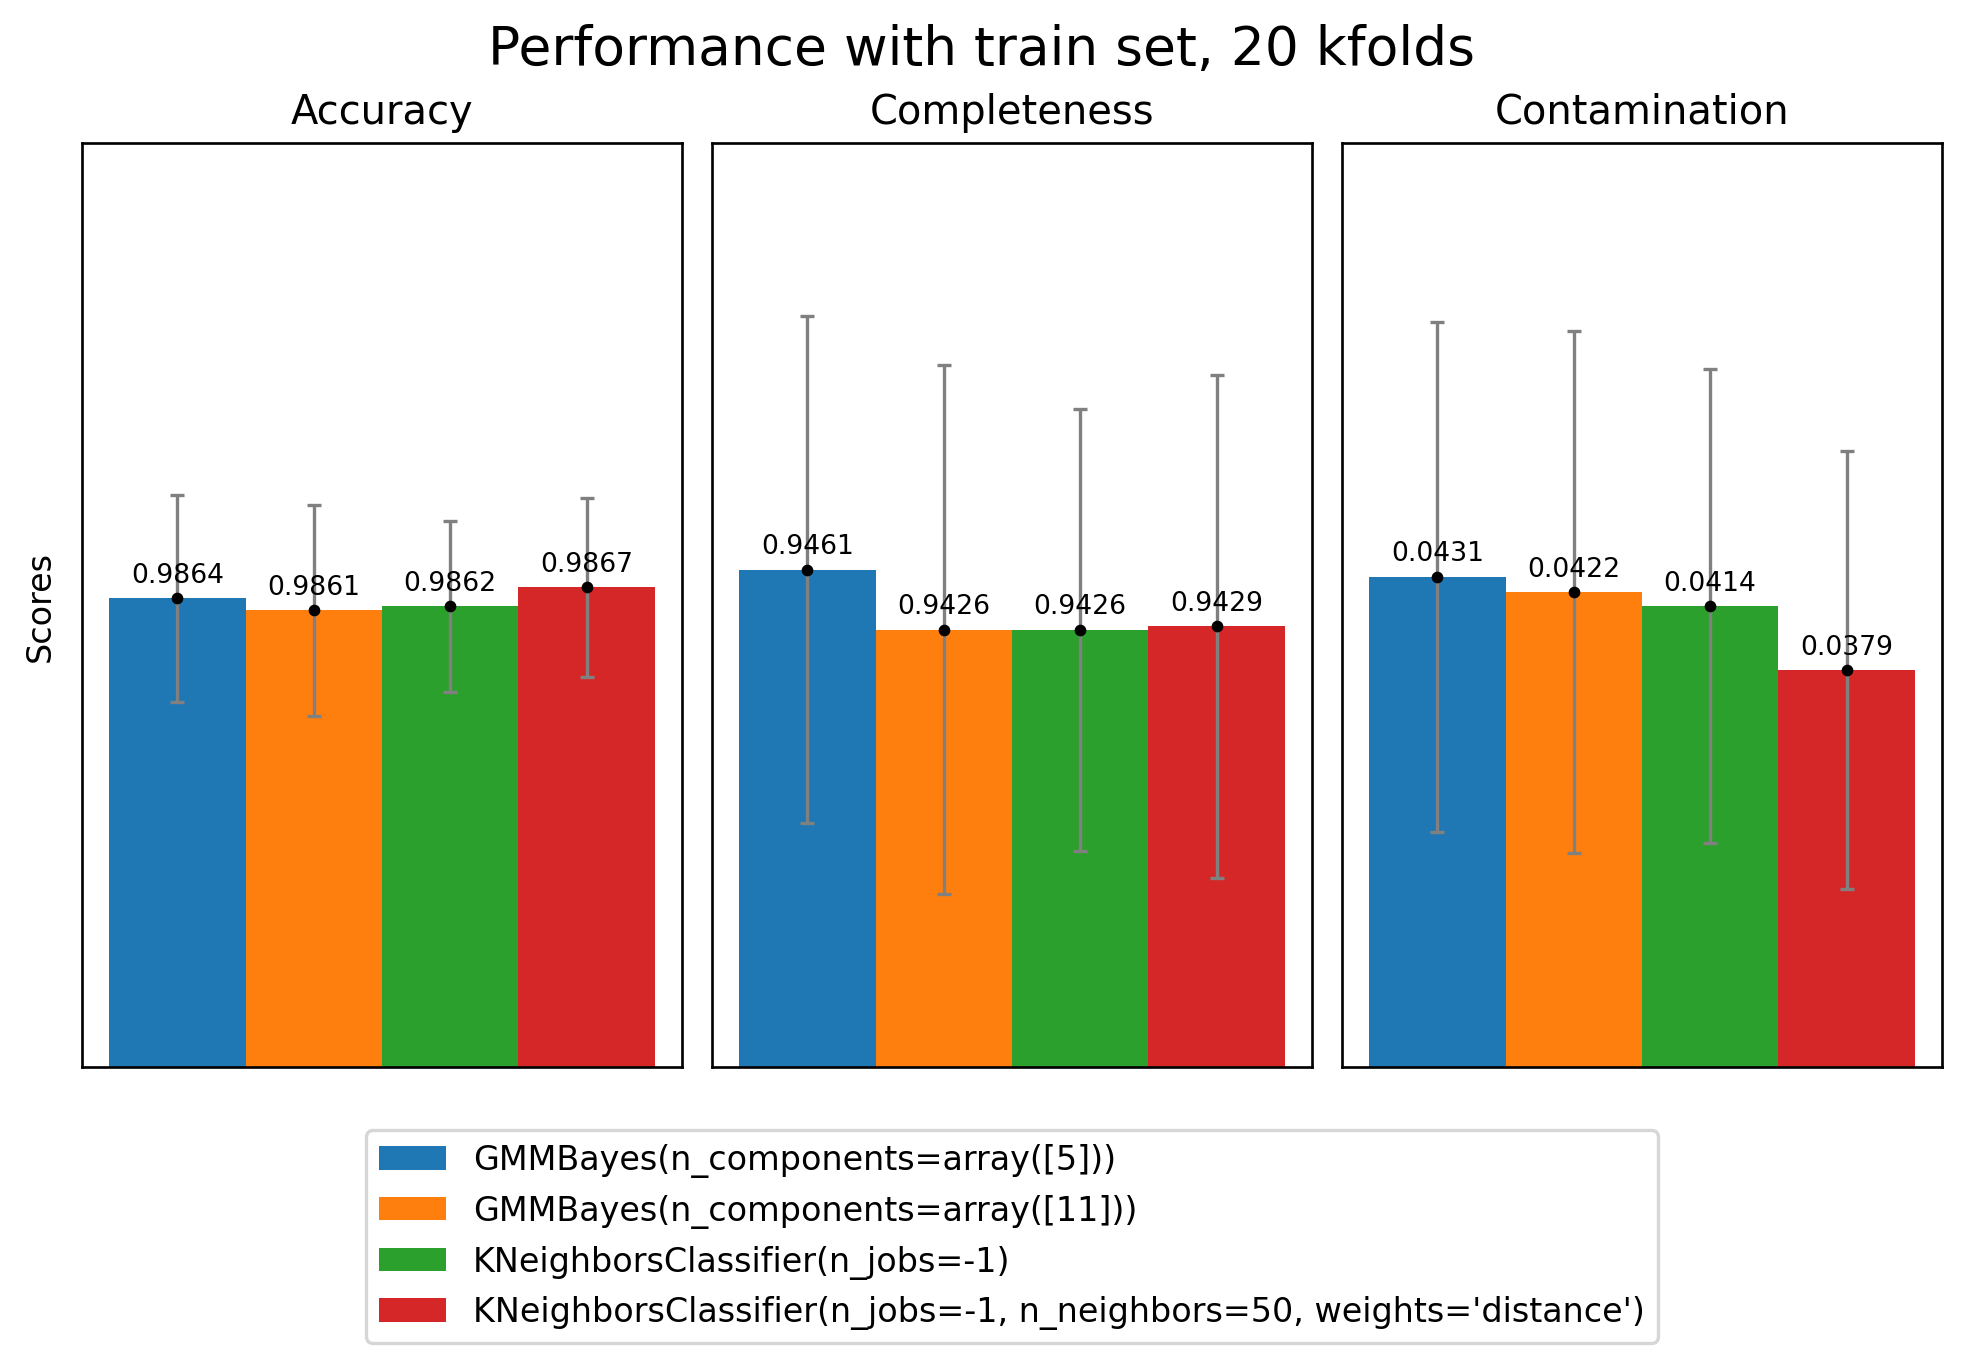

In [48]:
cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c

a2 = compare_classifiers(info_list2, figtitle=f'Performance with train set, {kf} kfolds' )
# a2 = compare_classifiers(info_list2, figtitle='Performance with test set' )

Performance is very similar, and ranking is dominated by statistical fluctuations.
Evaluate performance on test set:

In [ ]:
info_list2 = run_classifier_list(classifiers_list2, test_metrics=True) 

,name,accuracy,completeness,contamination
2,KNeighborsClassifier(n_jobs=-1),0.987240,0.943783,0.035071
3,"KNeighborsClassifier(n_jobs=-1, n_neighbors=50...",0.986904,0.941401,0.035156
1,GMMBayes(n_components=array([11])),0.986568,0.938066,0.034331
0,GMMBayes(n_components=array([5])),0.985561,0.945688,0.048418


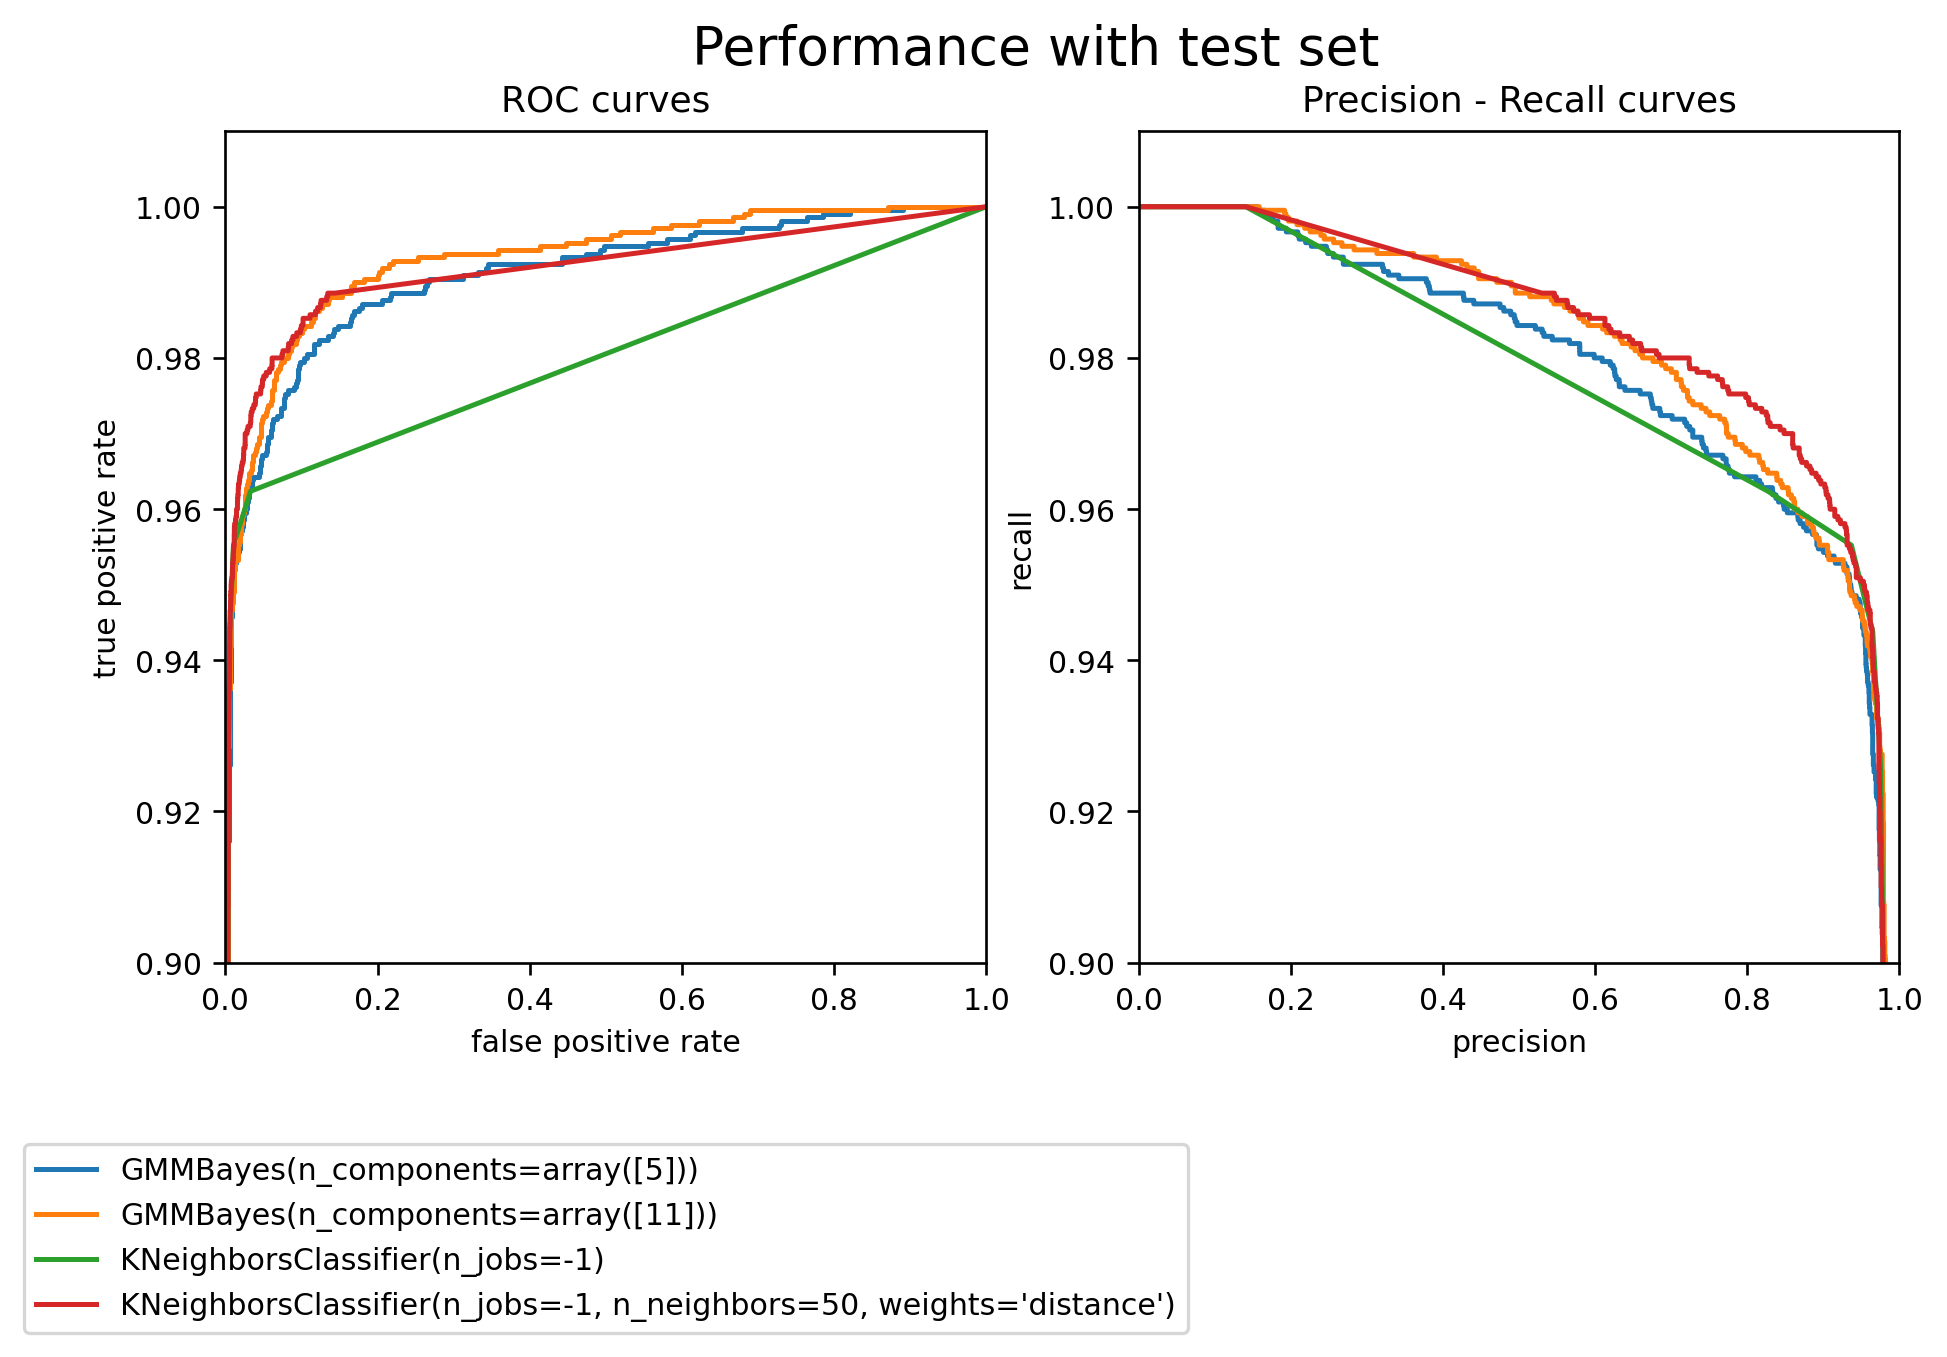

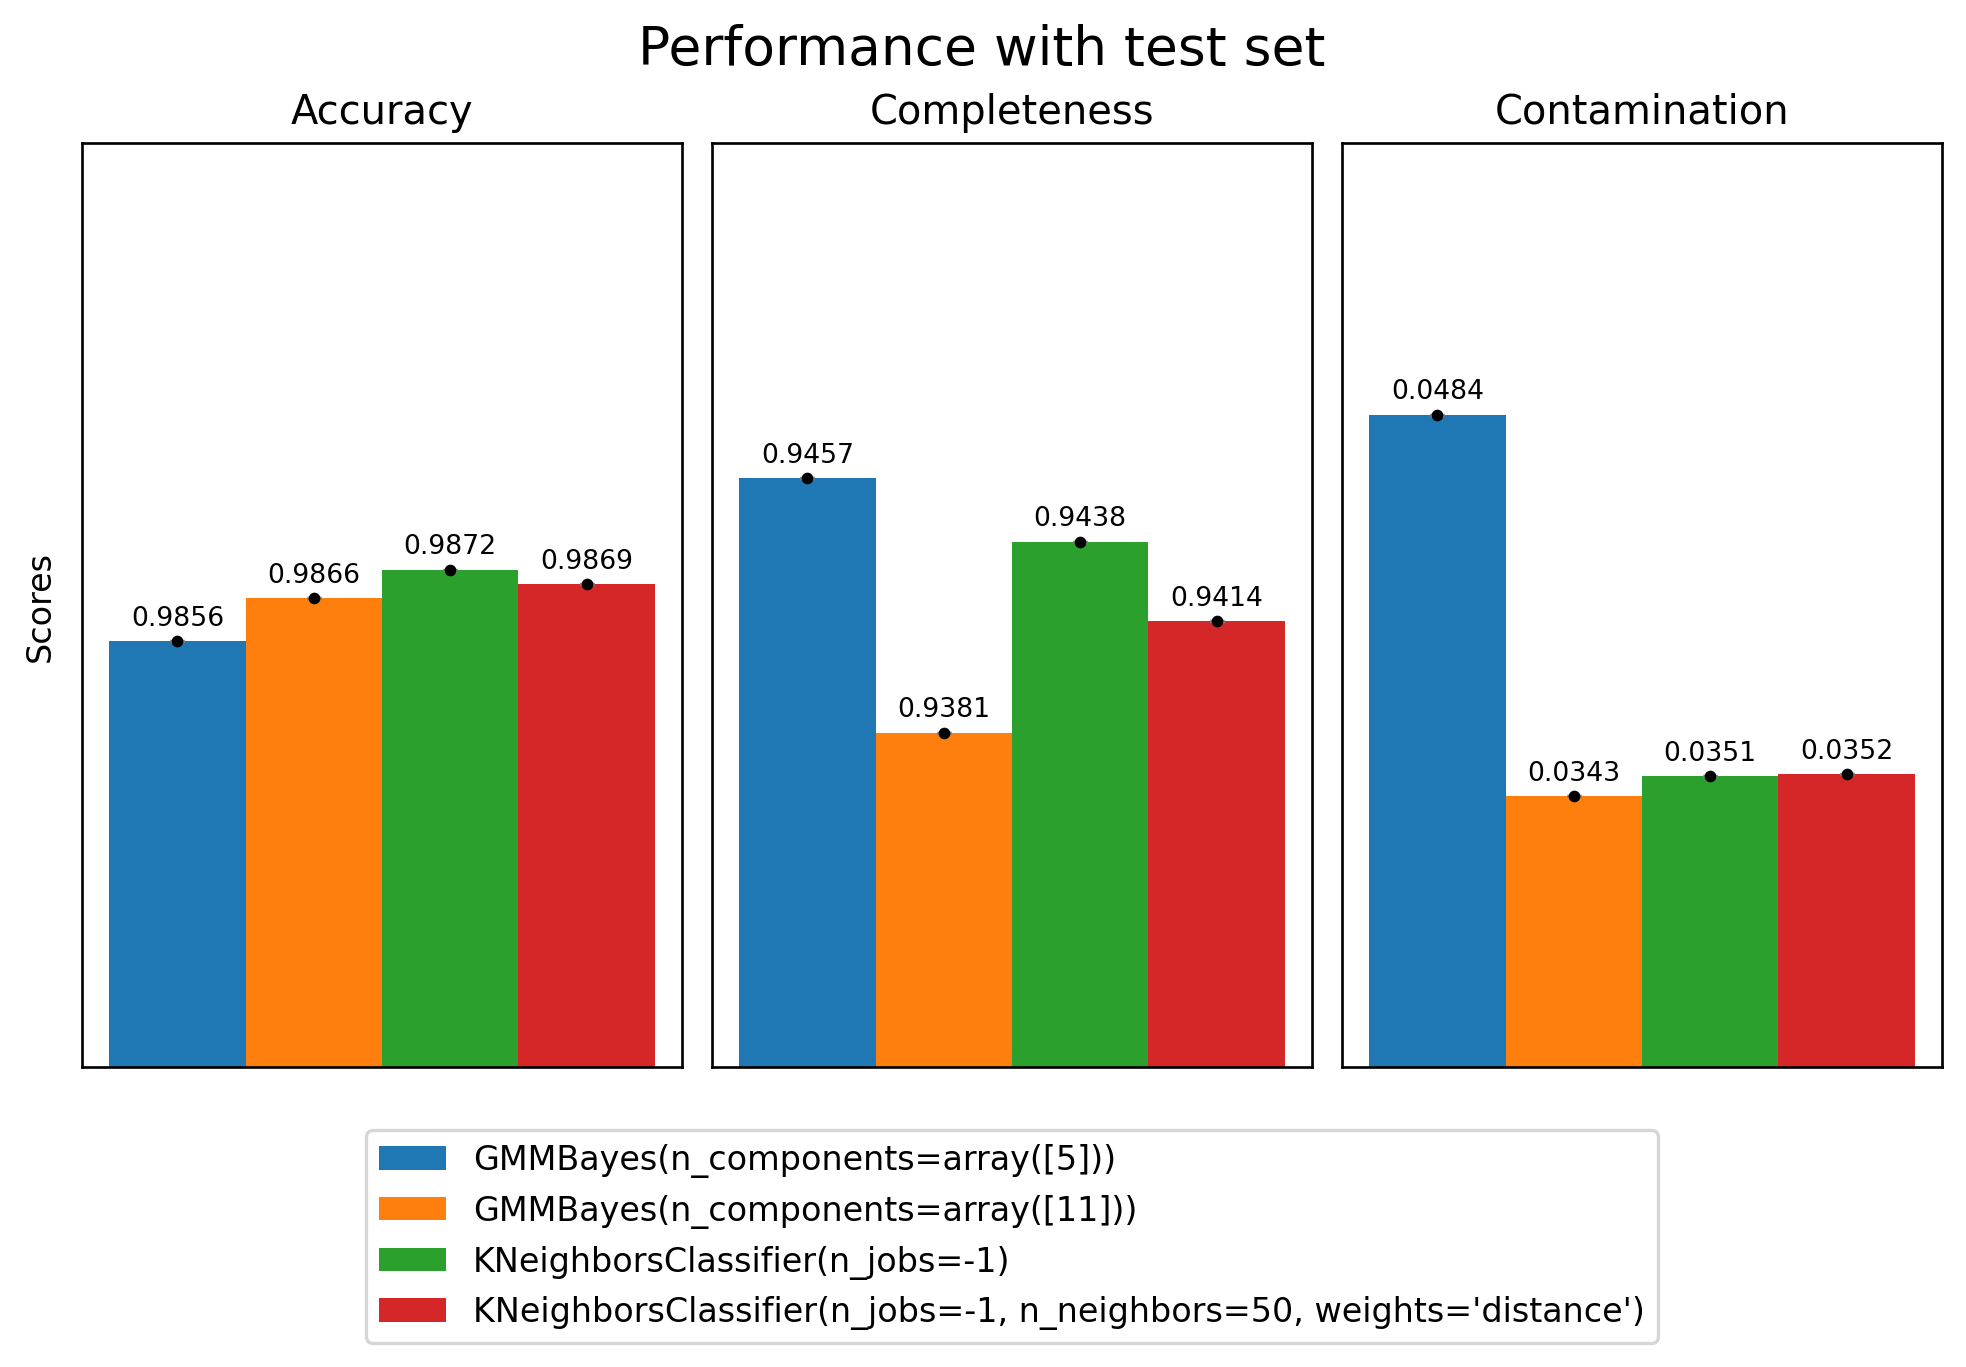

In [50]:
cmap=plt.cm.tab10
c = cycler('color', cmap(range(10)))
plt.rcParams["axes.prop_cycle"] = c

# a2 = compare_classifiers(info_list2, figtitle=f'Performance with train set, {kf} kfolds' )
a2 = compare_classifiers(info_list2, figtitle='Performance with test set' )

### Different features subsets
The best performing classifier is KNeighbors, the worst is Naive Bayes. Let's see how they manage with different color subsets:
- Only with u-g (most informative)
- Only with i-z (least informative)
- Adding other colors to u-g to see if classification performance is enhanced


In [50]:
def compute_models_new(xtrain, xtest, *args):
    names = []
    probs = []
    preds = []
    completeness = []
    contamination = []
    accuracy = []
    classifiers = []
    
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(xtrain, y_train)
        
        classifiers.append(clf)
        y_probs = clf.predict_proba(xtest)[:, 1]
        y_pred = clf.predict(xtest)
        complet = recall_score(y_test, y_pred)
        contam = 1 - precision_score(y_test, y_pred)
        accur = accuracy_score(y_test, y_pred)
        
        names.append(classifier.__name__)
        probs.append(y_probs)
        preds.append(y_pred)
        completeness.append(float(complet))
        contamination.append(float(contam))
        accuracy.append(accur)


    return completeness, contamination, accuracy, preds


In [51]:
data_list = []

# Only u-g
xtrain = X_train[:,0][:,None]
xtest = X_test[:,0][:,None]
data_list.append([xtrain,xtest])

# Only i-z
xtrain = X_train[:,3][:,None]
xtest = X_test[:,3][:,None]
data_list.append([xtrain,xtest])

# U-g adding all other colors in sequence
for i in range(1,4):
    xtrain = X_train[:,:i]
    xtest = X_test[:,:i]
    data_list.append([xtrain,xtest])


In [52]:
# These lists store results for different combinations, with dimensions (5,2)
complet_list = []
contam_list = []
accu_list = []
pred_list = []


for data in data_list:
    completeness, contamination, accuracy, predictions = \
        compute_models_new(data[0], data[1], (GaussianNB, {}), (KNeighborsClassifier, dict(n_neighbors=6)))
    
    complet_list.append(completeness)
    contam_list.append(contamination)
    accu_list.append(accuracy)
    pred_list.append(predictions)
    
complet_arr = np.array(complet_list).T
contam_arr = np.array(contam_list).T
accu_arr = np.array(accu_list).T
# clf_arr = np.array(clf_list).T

metrics_list = [accu_arr, complet_arr, contam_arr]
names = ['accuracy', 'recall / completeness', 'contamination']

GaussianNB
KNeighborsClassifier
GaussianNB
KNeighborsClassifier
GaussianNB
KNeighborsClassifier
GaussianNB
KNeighborsClassifier
GaussianNB
KNeighborsClassifier


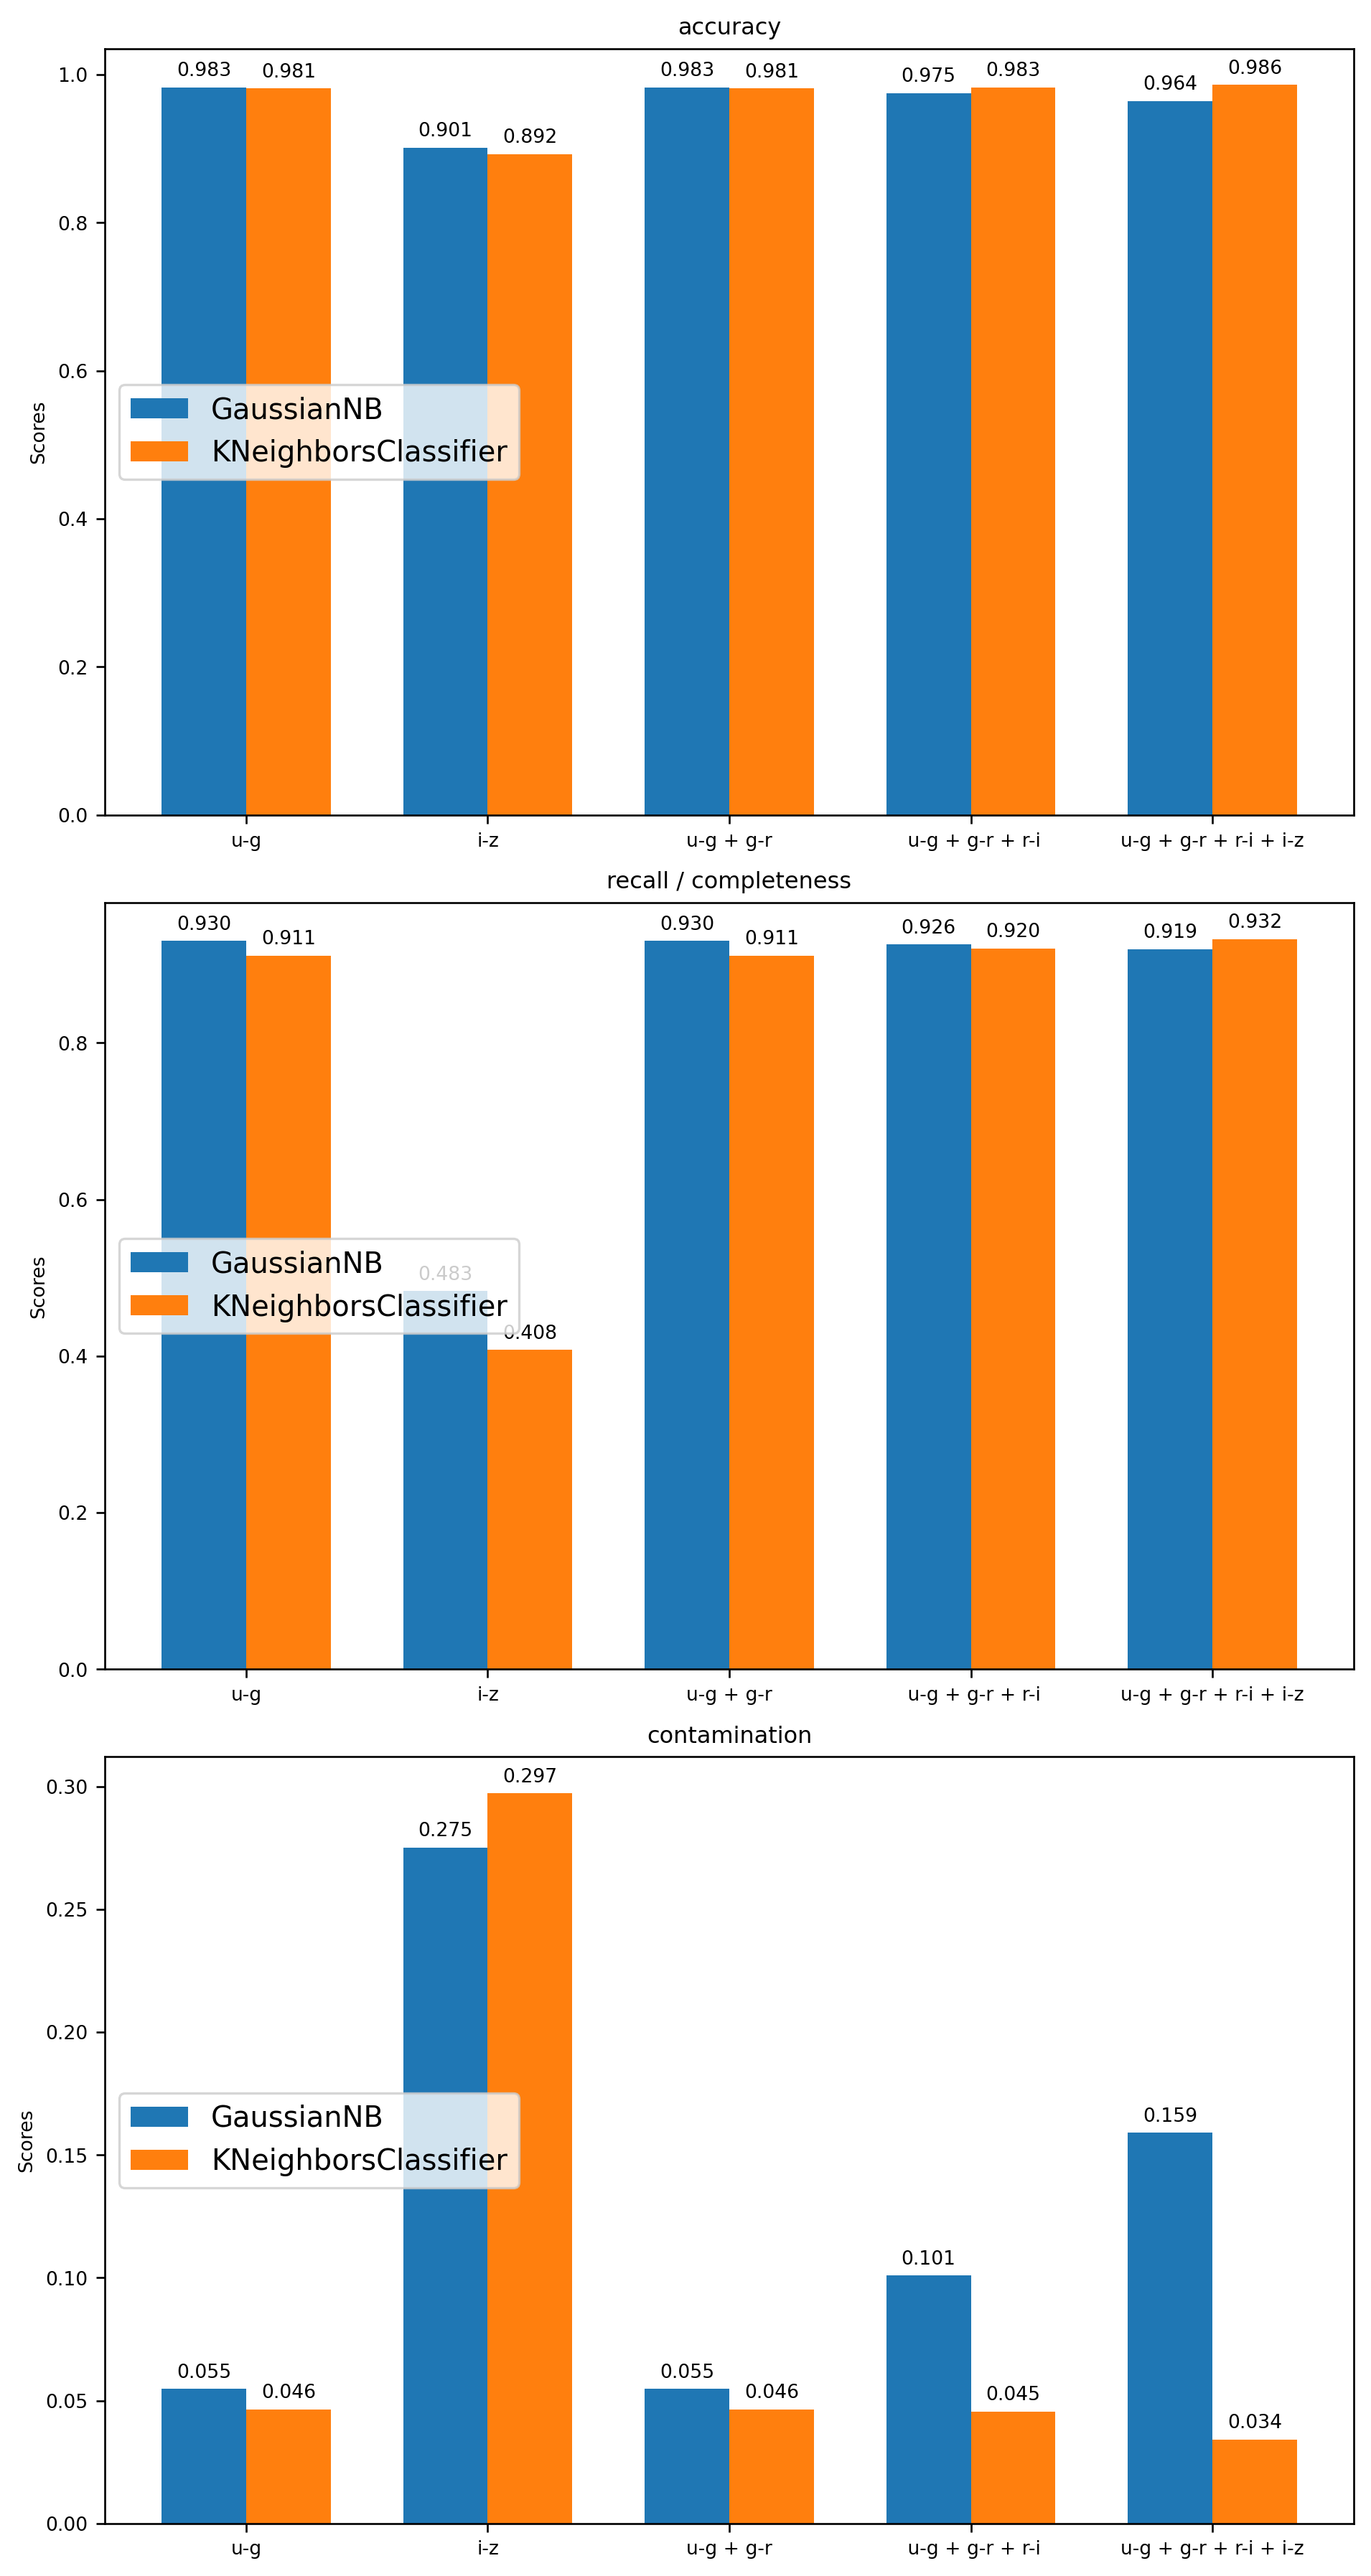

In [53]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(8,15), dpi=120)
plt.rcParams.update({'font.size': 8})
#--------------------------------------------

labels = ['u-g', 'i-z', 'u-g + g-r',' u-g + g-r + r-i', 'u-g + g-r + r-i + i-z']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Accuracy

fig, axs = plt.subplots(3,1)

for ax,metric,name in zip(axs.flatten(), metrics_list, names):
    
    rects1 = ax.bar(x - width/2, metric[0], width, label='GaussianNB')
    rects2 = ax.bar(x + width/2, metric[1], width, label='KNeighborsClassifier')

    ax.set_ylabel('Scores')
    ax.set_title(name)
    ax.set_xticks(x, labels)

    ax.legend(loc='center left', fontsize=12)

    ax.bar_label(rects1, padding=3, fmt='%.3f')
    ax.bar_label(rects2, padding=3, fmt='%.3f')

fig.tight_layout()

Using only i-z feature:
- Both classifiers performs quite badly, as completeness is very low and contamination is high

About the "Naive assumption" of feature independence:
- NaiveBayes is impacted from this fact, as we can see that it obtains the highest accuracy score using only the u-g feature, and gets worse adding more features.
- K-Neighbors on the contrary performs better when adding more features.


## PCA transformation


In [ ]:
from sklearn. decomposition import PCA, KernelPCA, FastICA

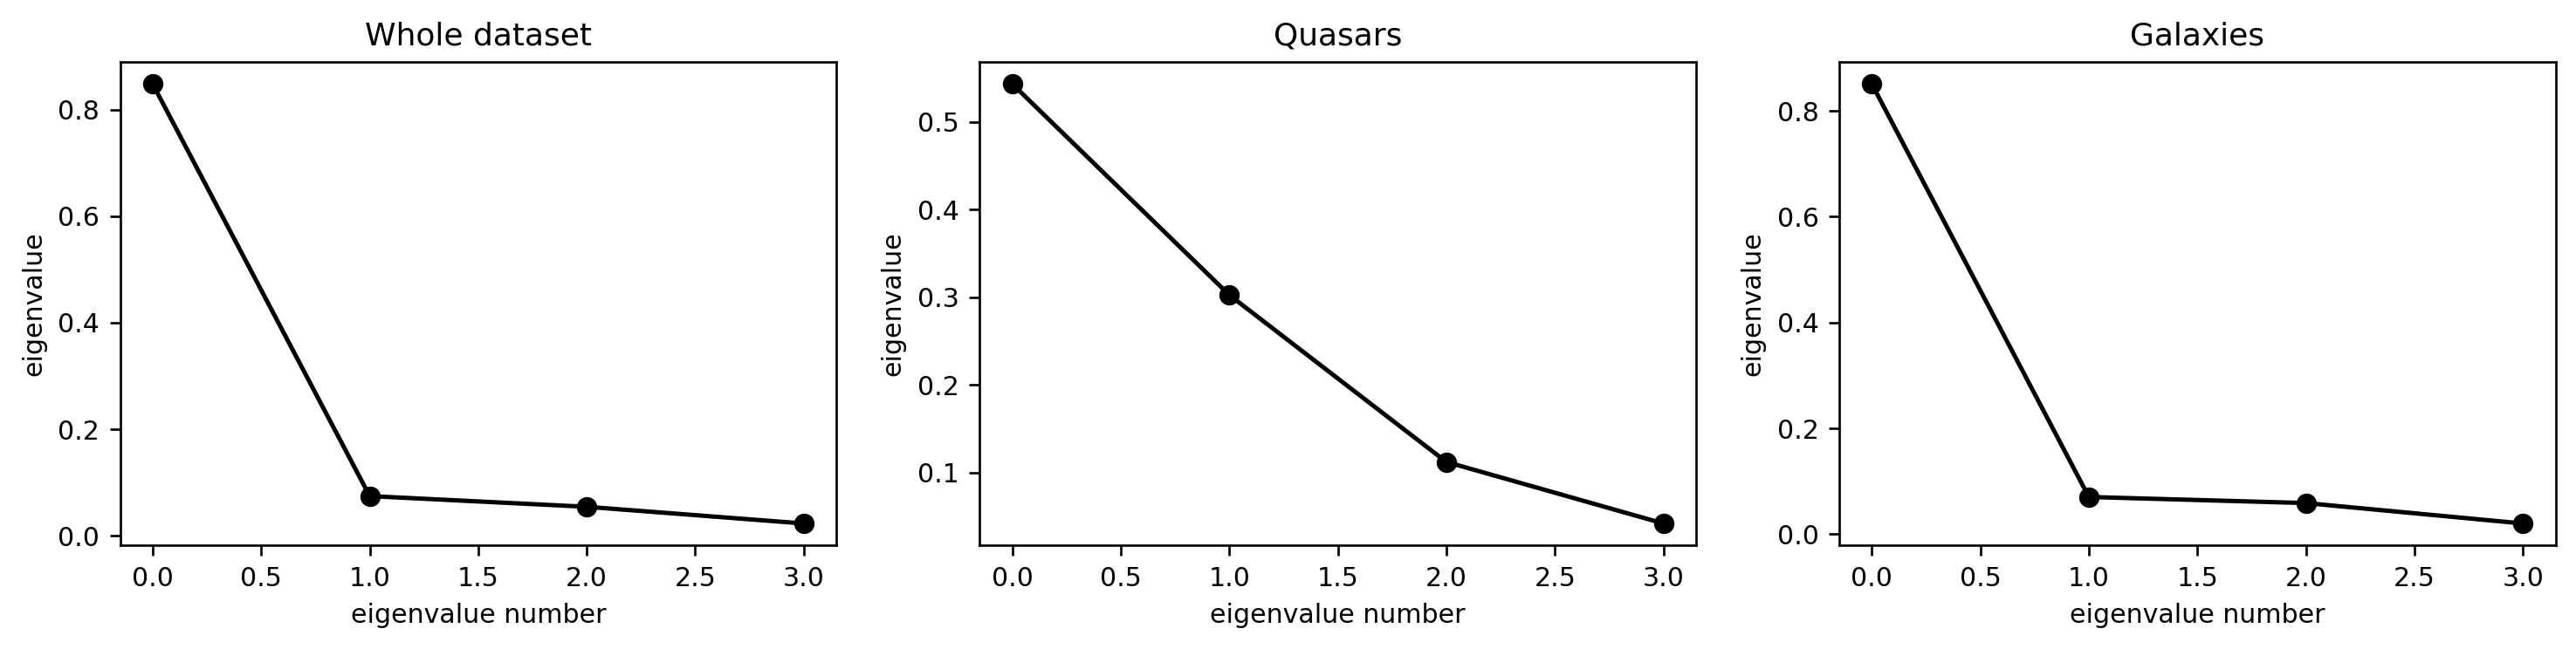

In [82]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(15,3), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig,ax = plt.subplots(1,3)

n_components = len(X_train[0,:])

pca = PCA(n_components = n_components)

pca.fit(X_train)
evals = pca.explained_variance_ratio_ 
ax[0].plot(np.arange(n_components), evals, '-ok')
ax[0].set_xlabel('eigenvalue number')
ax[0].set_ylabel('eigenvalue')
ax[0].set_title('Whole dataset')

pca.fit(X_train[y_train==1])
evals = pca.explained_variance_ratio_ 
ax[1].plot(np.arange(n_components), evals, '-ok')
ax[1].set_xlabel('eigenvalue number')
ax[1].set_ylabel('eigenvalue')
ax[1].set_title('Quasars')

pca.fit(X_train[y_train==0])
evals = pca.explained_variance_ratio_ 
ax[2].plot(np.arange(n_components), evals, '-ok')
ax[2].set_xlabel('eigenvalue number')
ax[2].set_ylabel('eigenvalue')
ax[2].set_title('Galaxies')

plt.tight_layout;

In [91]:
pca.fit(X_train)
comp = pca.components_
print(comp)

[[-0.50732076 -0.52231905 -0.48536975 -0.48396762]
 [ 0.00948854 -0.02765205 -0.6957633   0.71767595]
 [ 0.68252454  0.24197986 -0.49530082 -0.47987822]
 [-0.52601889  0.81722942 -0.18710086 -0.1429457 ]]


In [92]:
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)

X_pca = np.concatenate((X_pca_test, X_pca_train))
y_pca = np.concatenate((y_test,y_train))

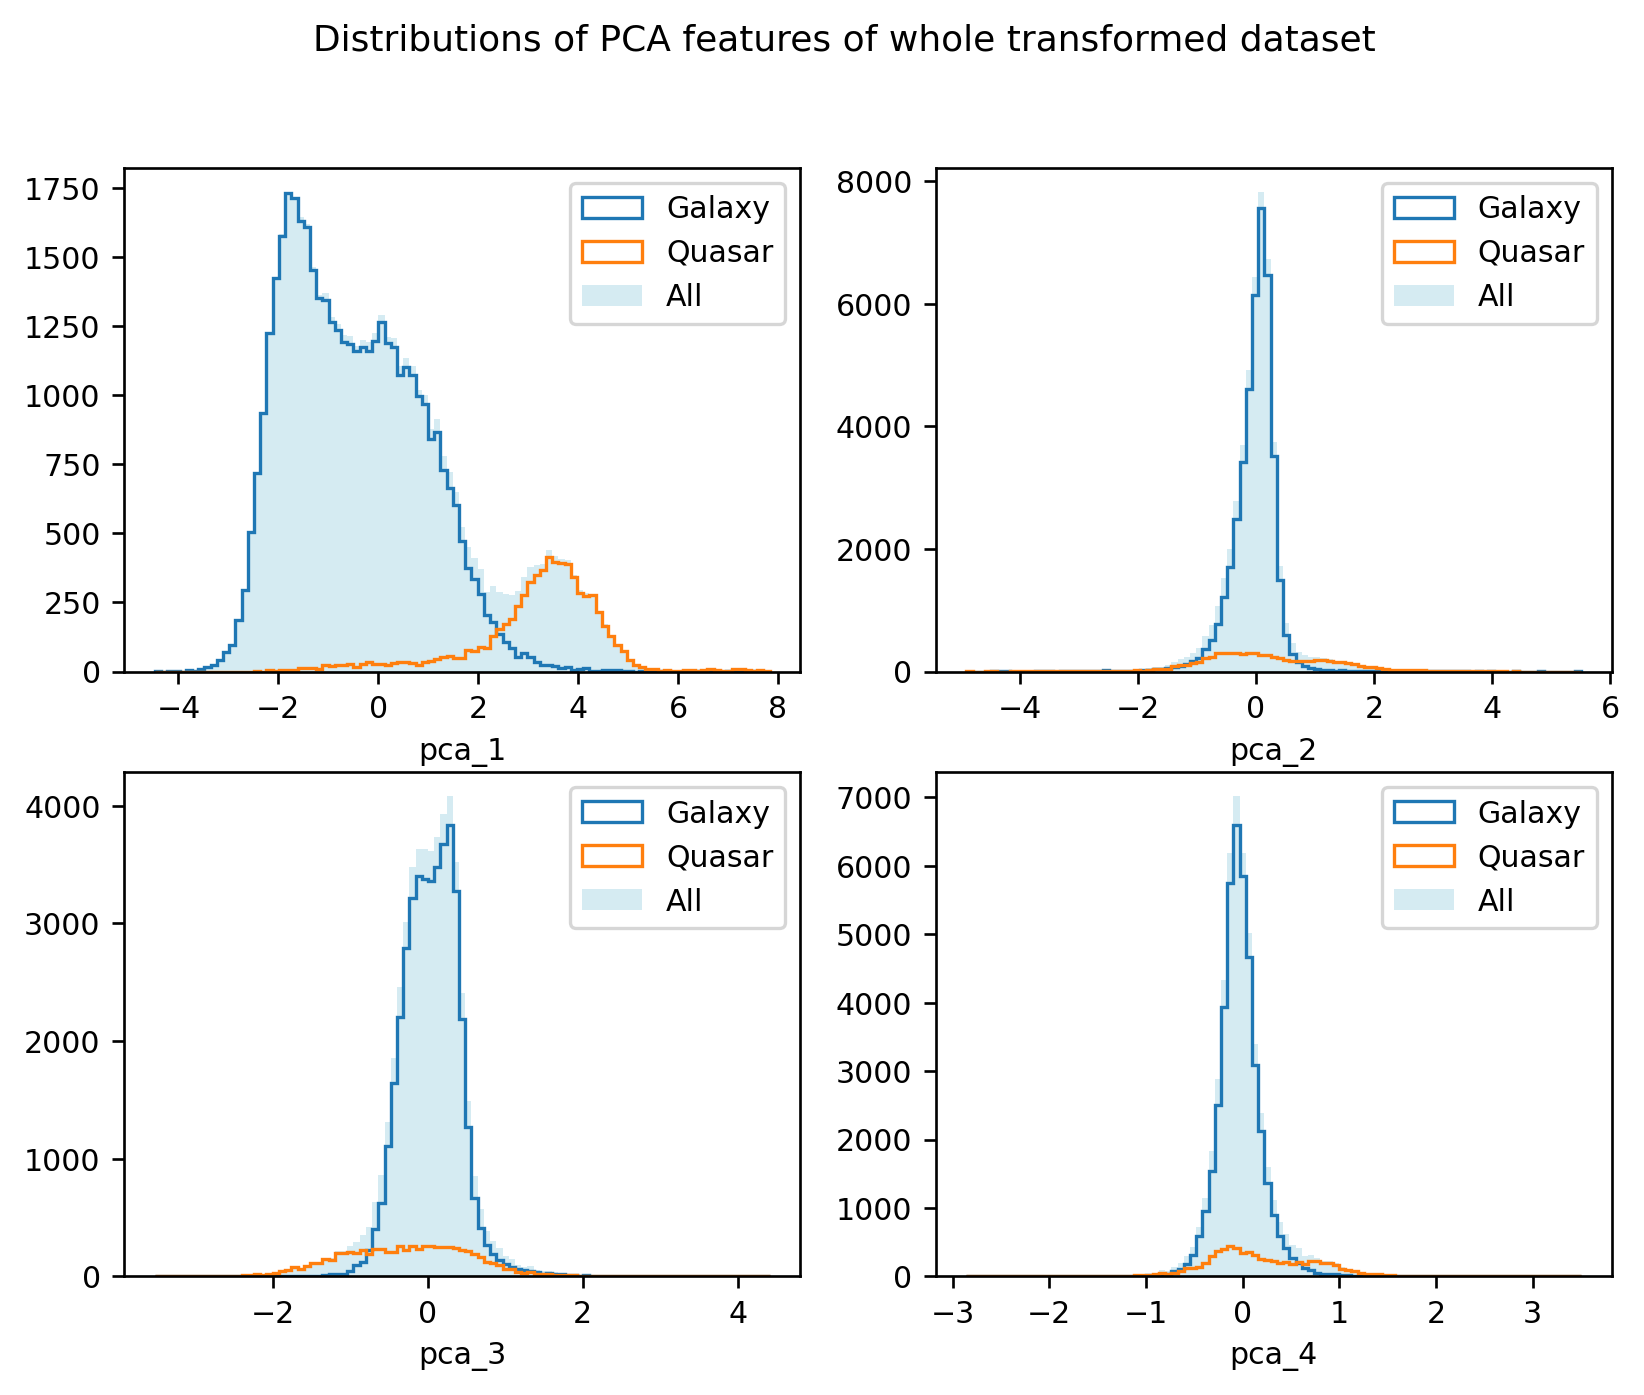

In [94]:
# Distribution of PCA features

#-------  Plt params  ----------------
plt.rc('figure', figsize=(8,6), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig, axs = plt.subplots(2,2)

fig.suptitle('Distributions of PCA features of whole transformed dataset')


for ax,color, name in zip(axs.flatten() ,X_pca.T, ['pca_1', 'pca_2', 'pca_3', 'pca_4']):
    bins = np.linspace(np.min(color), np.max(color), 100)
    gala = color[y_pca==0]
    quas = color[y_pca==1]
    ax.hist(gala, bins=bins, histtype = 'step', label = 'Galaxy', lw=1)
    ax.hist(quas, bins=bins, histtype = 'step', label = 'Quasar', lw=1)
    ax.hist(color, bins=bins, label = 'All', color='lightblue', alpha=0.5,)
    ax.legend()
    ax.set_xlabel(name)
    
    # ax.set_yscale('log')
    
plt.tight_layout;

Let's try and run the last two Classifiers.

In [95]:
data_list = []

# Only u-g
xtrain = X_pca_train[:,0][:,None]
xtest = X_pca_test[:,0][:,None]
data_list.append([xtrain,xtest])

# Only i-z
xtrain = X_pca_train[:,3][:,None]
xtest = X_pca_test[:,3][:,None]
data_list.append([xtrain,xtest])

# U-g adding all other colors in sequence
for i in range(1,4):
    xtrain = X_pca_train[:,:i]
    xtest = X_pca_test[:,:i]
    data_list.append([xtrain,xtest])


In [96]:
# These lists store results for different combinations, with dimensions (5,2)
complet_list = []
contam_list = []
accu_list = []
pred_list = []


for data in data_list:
    completeness, contamination, accuracy, predictions = \
        compute_models_new(data[0], data[1], (GaussianNB, {}), (KNeighborsClassifier, dict(n_neighbors=6)))
    
    complet_list.append(completeness)
    contam_list.append(contamination)
    accu_list.append(accuracy)
    pred_list.append(predictions)
    
complet_arr = np.array(complet_list).T
contam_arr = np.array(contam_list).T
accu_arr = np.array(accu_list).T
# clf_arr = np.array(clf_list).T

metrics_list = [accu_arr, complet_arr, contam_arr]
names = ['accuracy', 'recall / completeness', 'contamination']

GaussianNB
KNeighborsClassifier
GaussianNB
KNeighborsClassifier
GaussianNB
KNeighborsClassifier
GaussianNB
KNeighborsClassifier
GaussianNB
KNeighborsClassifier


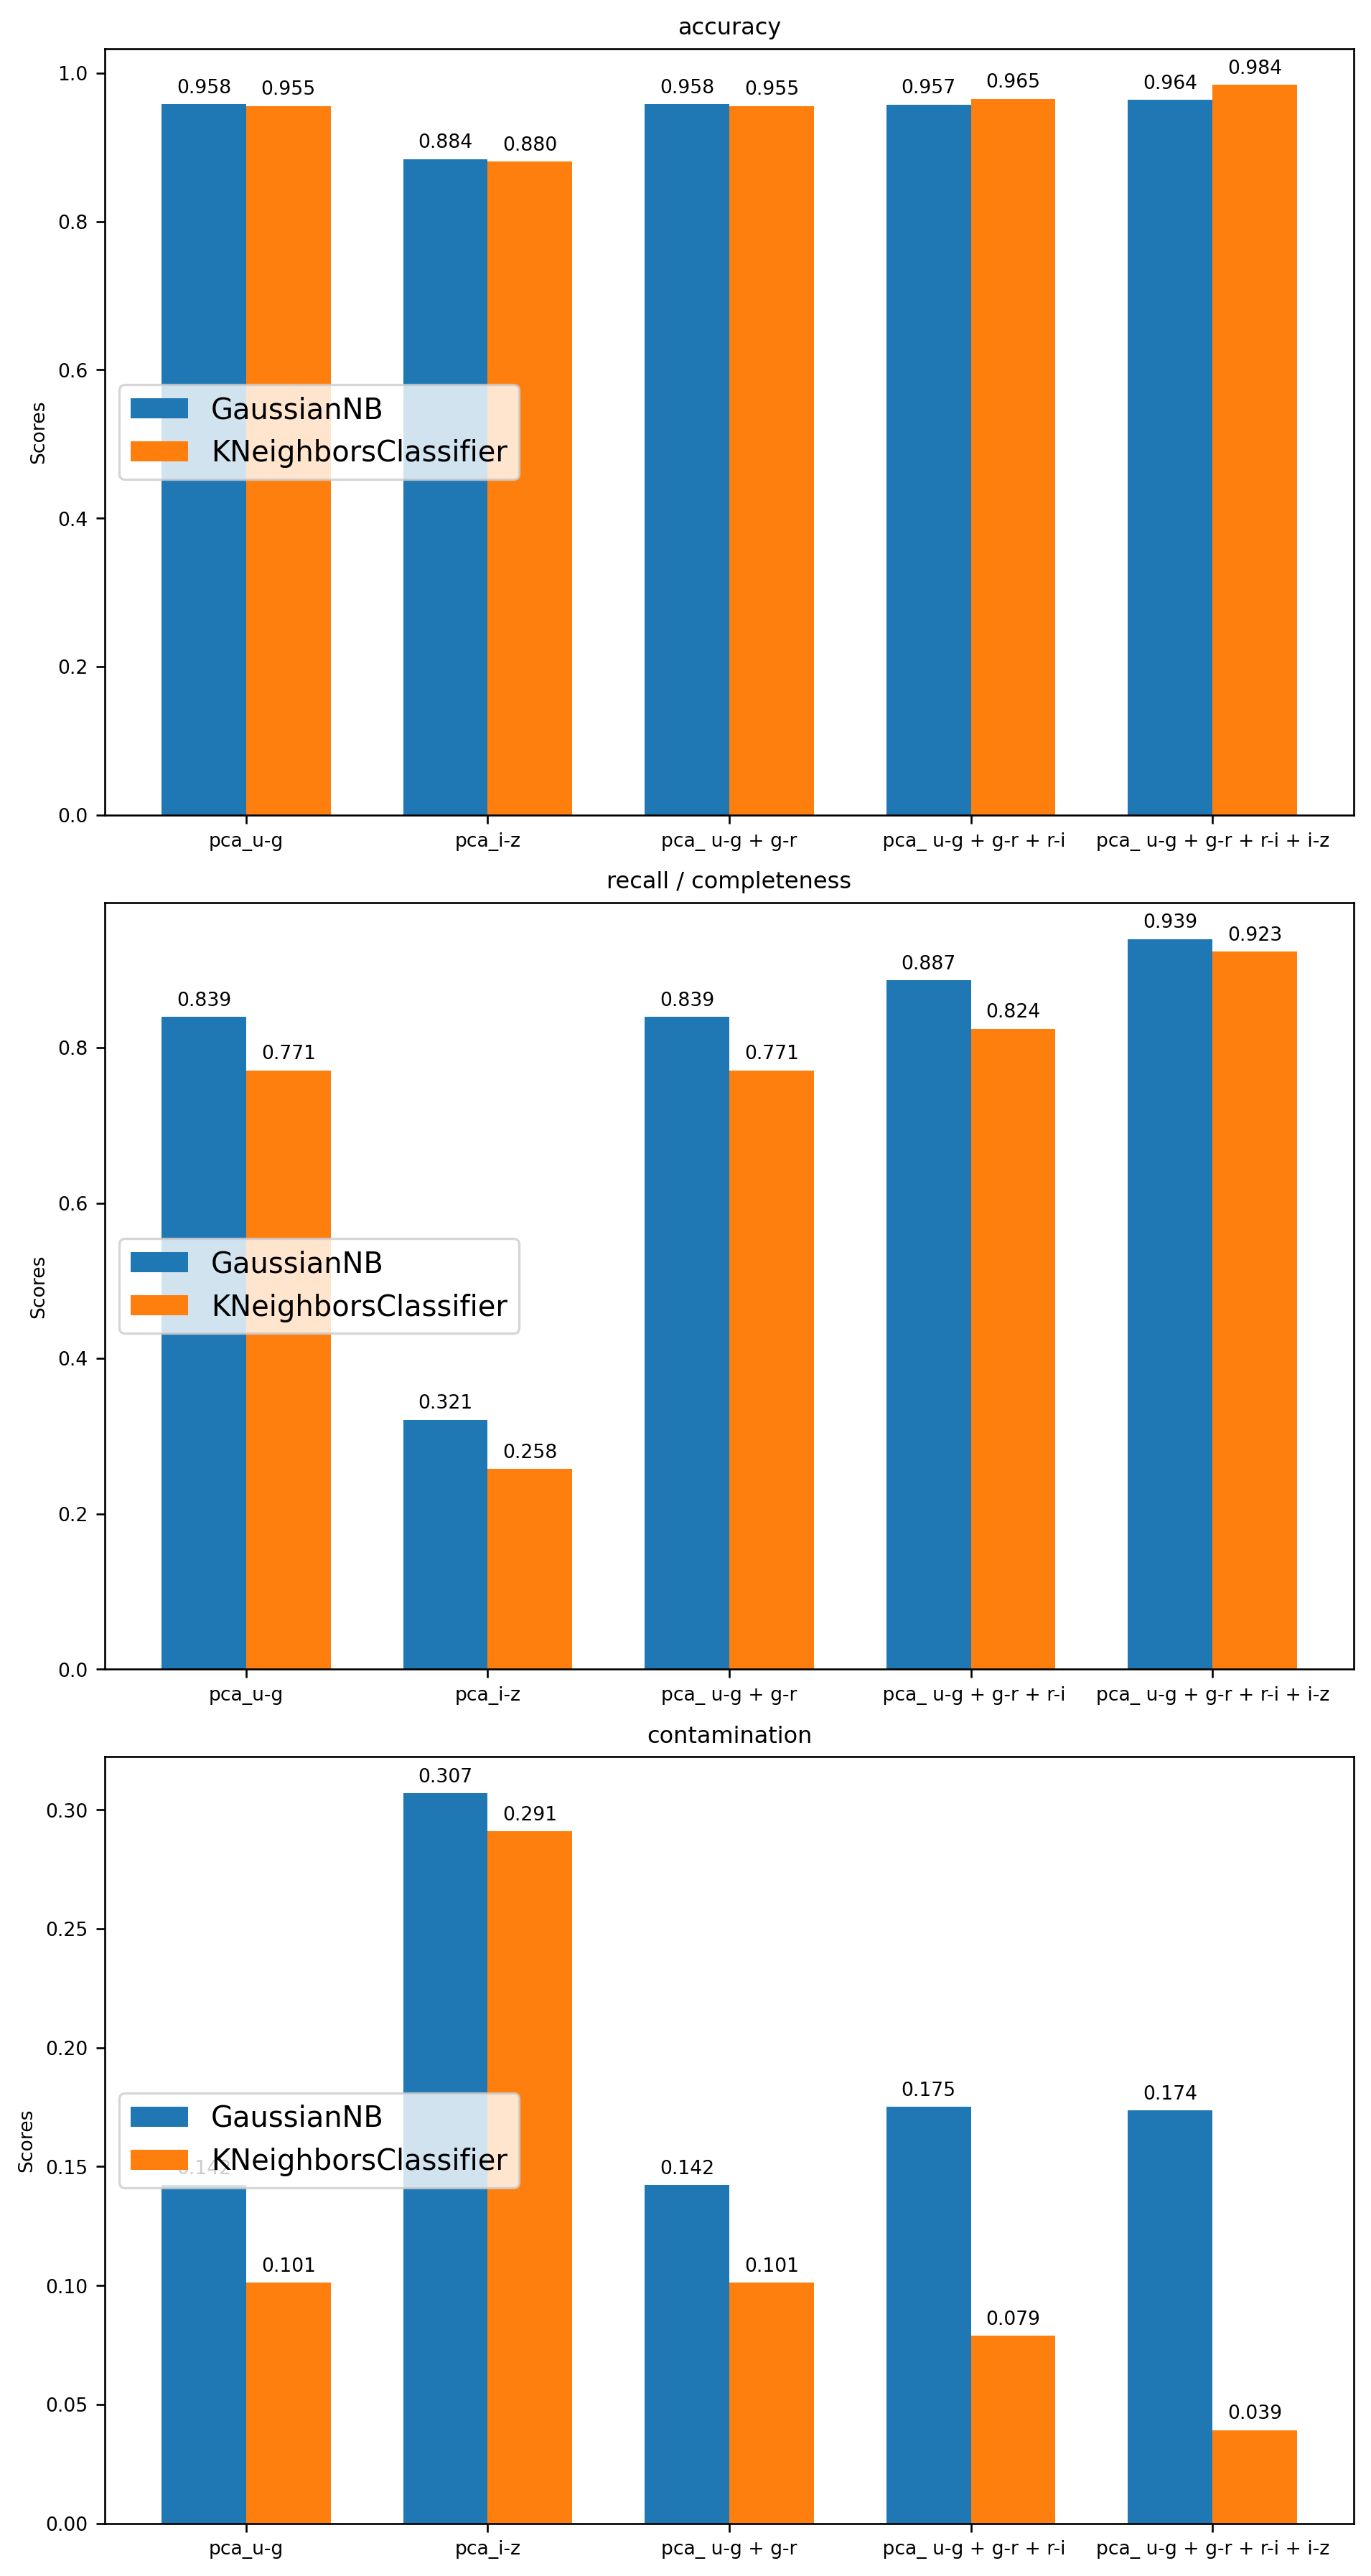

In [98]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(8,15), dpi=120)
plt.rcParams.update({'font.size': 8})
#--------------------------------------------

labels = ['pca_u-g', 'pca_i-z', 'pca_ u-g + g-r',' pca_ u-g + g-r + r-i', 'pca_ u-g + g-r + r-i + i-z']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Accuracy

fig, axs = plt.subplots(3,1)

for ax,metric,name in zip(axs.flatten(), metrics_list, names):
    
    rects1 = ax.bar(x - width/2, metric[0], width, label='GaussianNB')
    rects2 = ax.bar(x + width/2, metric[1], width, label='KNeighborsClassifier')

    ax.set_ylabel('Scores')
    ax.set_title(name)
    ax.set_xticks(x, labels)

    ax.legend(loc='center left', fontsize=12)

    ax.bar_label(rects1, padding=3, fmt='%.3f')
    ax.bar_label(rects2, padding=3, fmt='%.3f')

fig.tight_layout()

- K - neighbors performance using all features worsened:
    - Accuracy from 0.986 to 0.984
    - Completeness from 0.932 to 0.923
    - Contamination from 0.034 to0.039



- NBayes performance got better, probably because with PCA we reduced the effect of correlation by mixing features so that the first PCA feature in proportion weights more then the original u-g feature:
    - Accuracy remained 0.964 
    - Completeness from 0.919 to 0.939
    - Contamination from 0.159 to 0.174